Improvement notes:
- good exmple for multiple possible rulesets, that would equally well explain the instances classified $(1,0)$, because they are so close to the decision boundary, that small changes in any feature flip the predictions. with the features ordered by importance, it is clear to get a single order

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [3]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [10]:
def load(focus_class):
    with open(f'clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           categorical_features=categorical_features,
                           feature_precisions=feature_precisions, state=state)
    return node

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [01:44,  2.23it/s]                         
Exact explainer: 247it [01:39,  2.22it/s]                         
Exact explainer: 247it [07:25,  1.86s/it]                         

CPU times: user 12min 7s, sys: 2min 13s, total: 14min 20s
Wall time: 10min 50s


In [6]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
CPU times: user 23min 11s, sys: 8.19 s, total: 23min 20s
Wall time: 23min 55s


# Individual Explanations

In [4]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

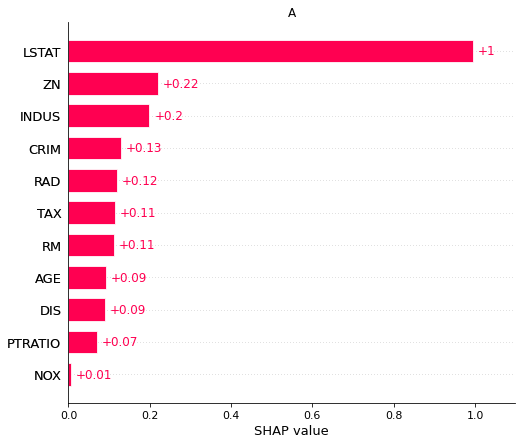

In [4]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

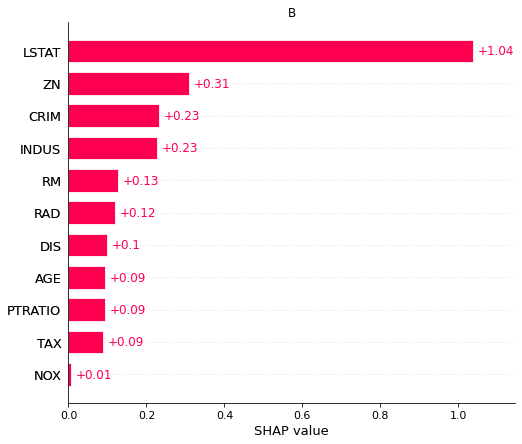

In [5]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['B.0', 'B.1', 'B.2']])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [6]:
feature_order, _ = calc_feature_order(indiv_shap_values)

In [7]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

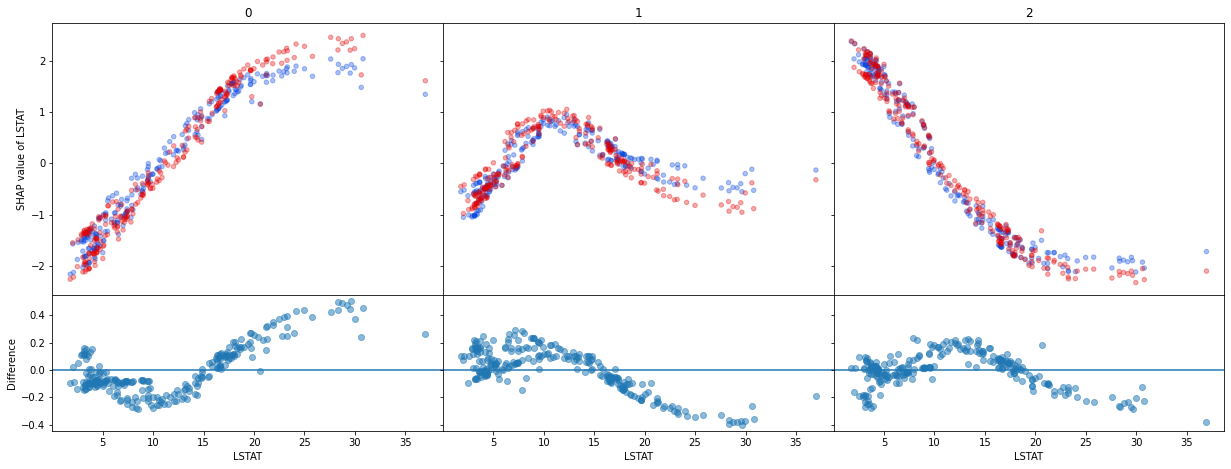

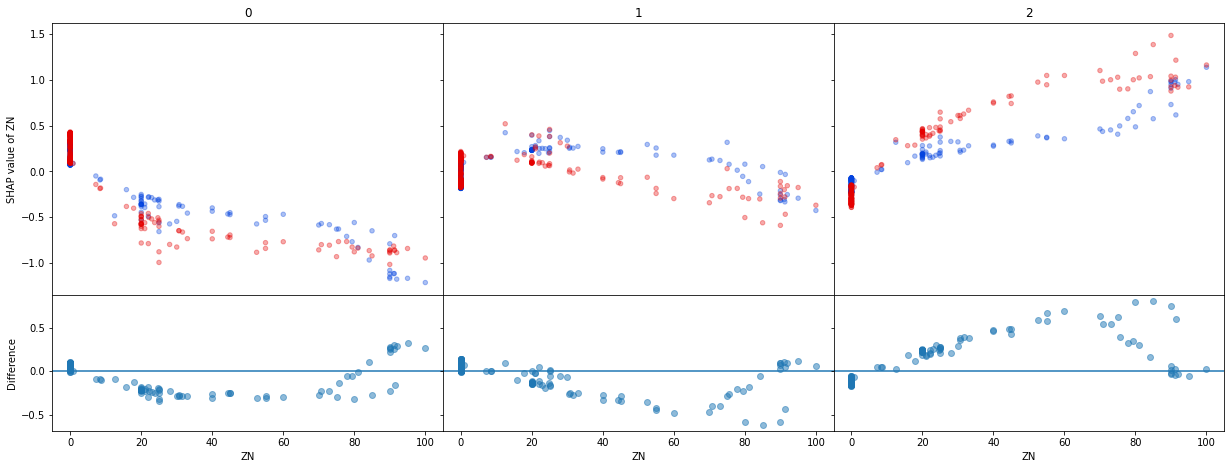

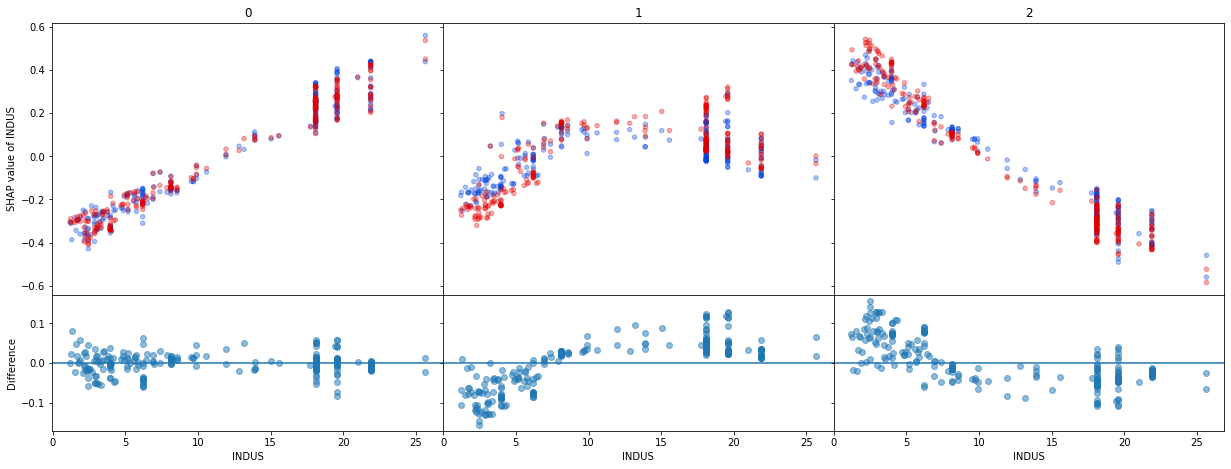

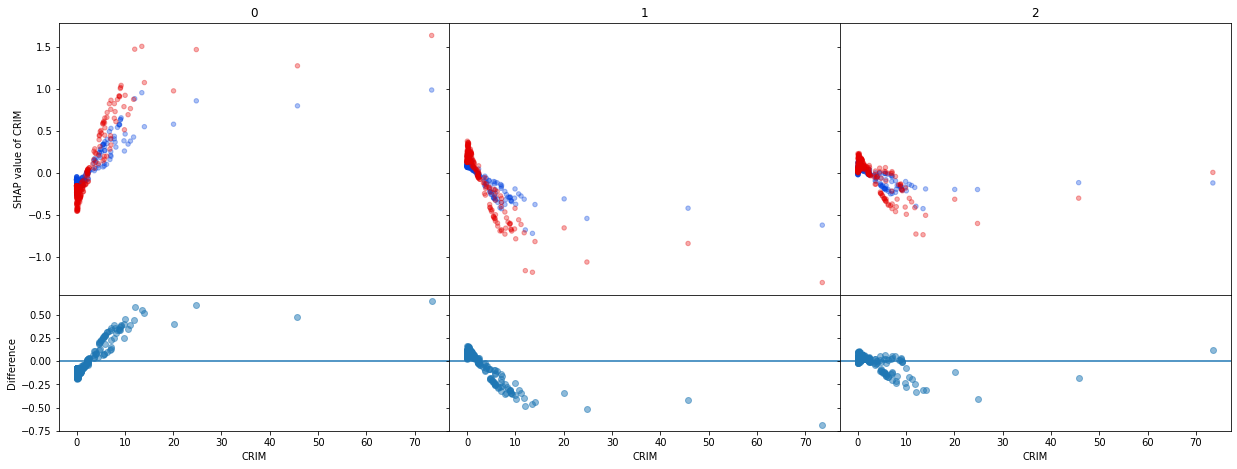

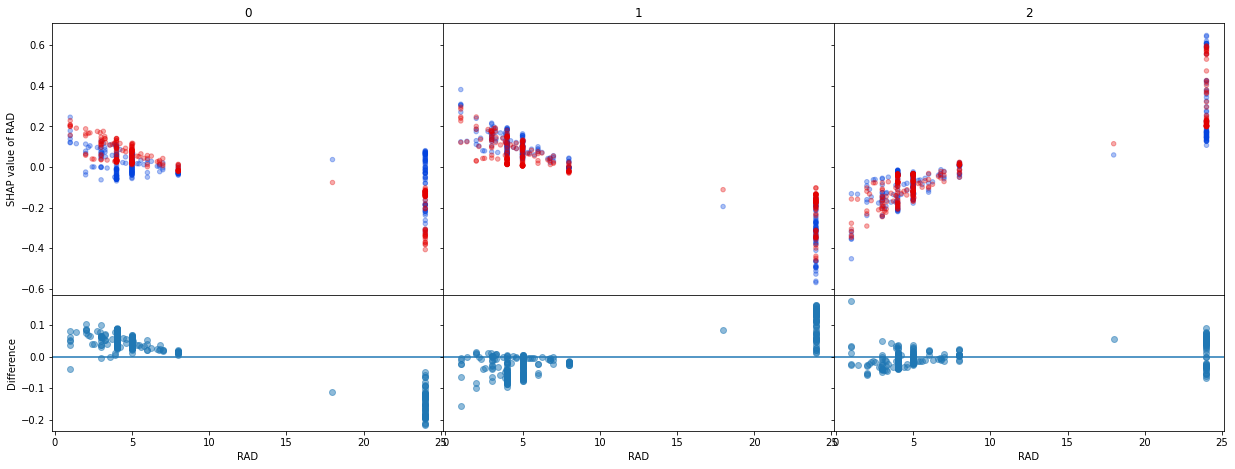

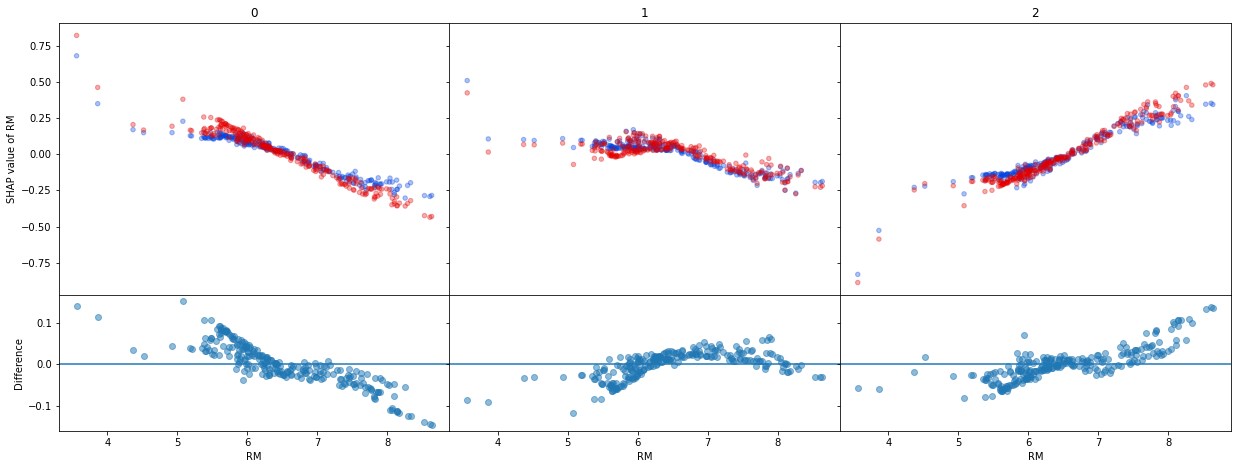

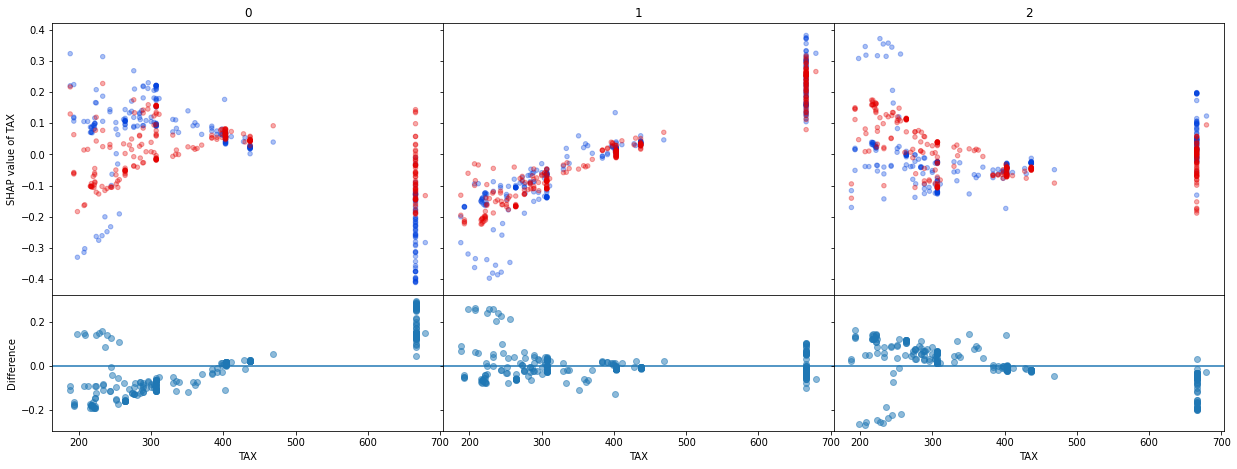

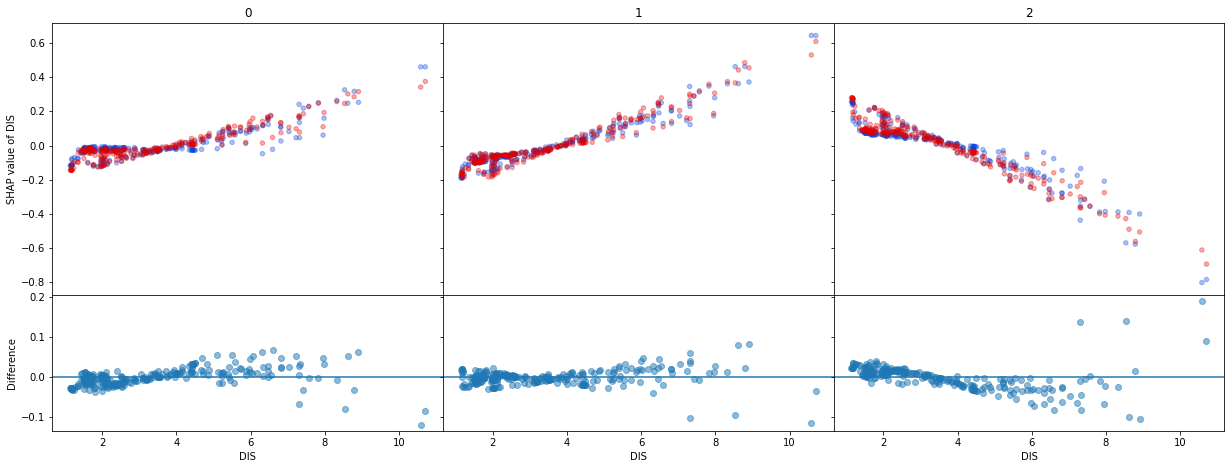

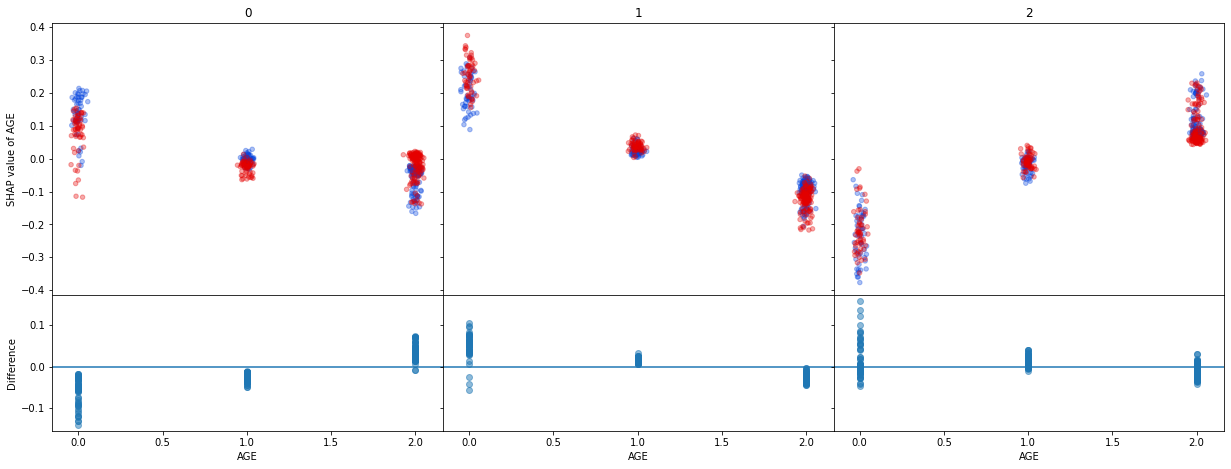

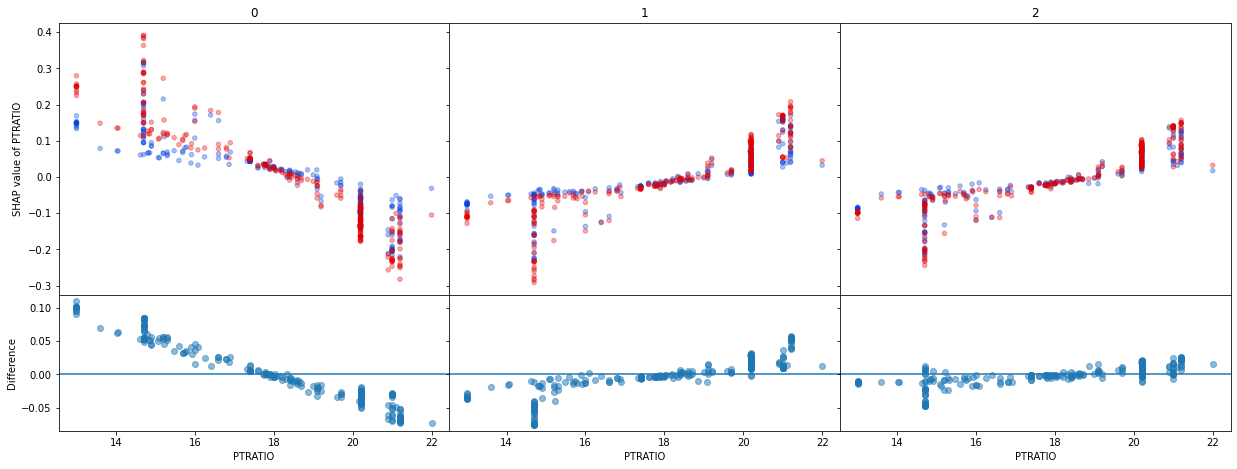

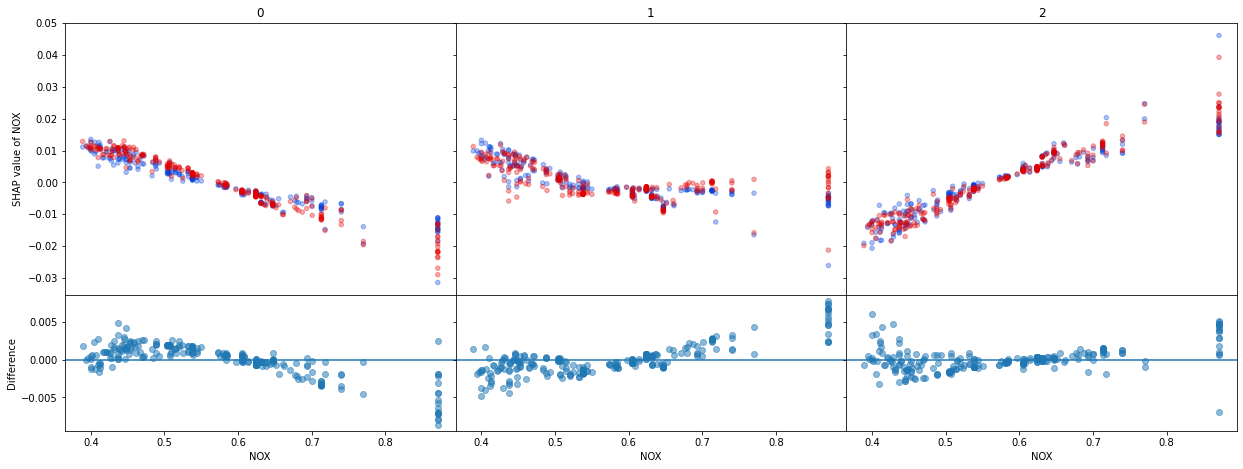

In [10]:
for feature in node.features_ordered:
    compare_indiv_dep_plots(node, feature)
    plt.show()

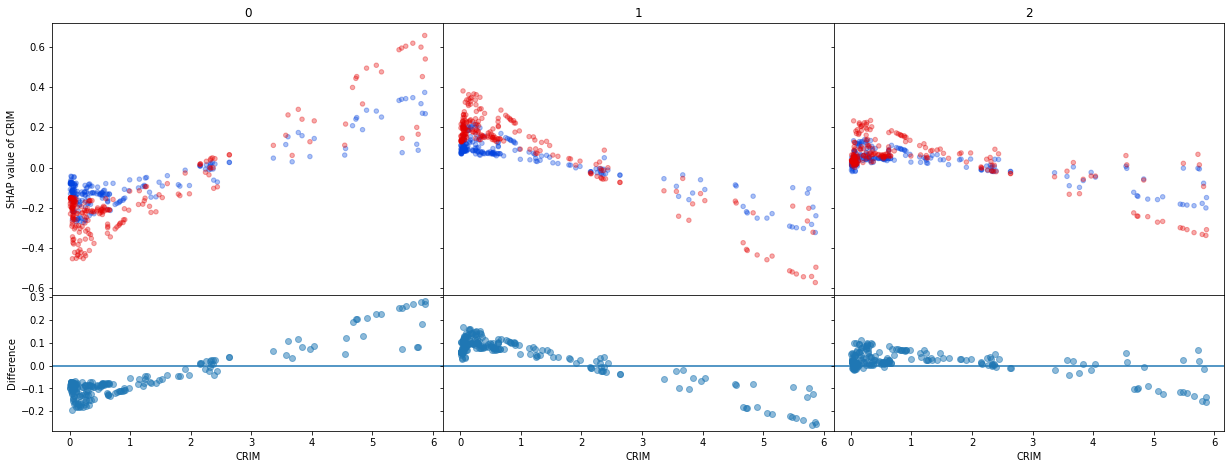

In [14]:
compare_indiv_dep_plots(node.filter('CRIM < 6'), 'CRIM')

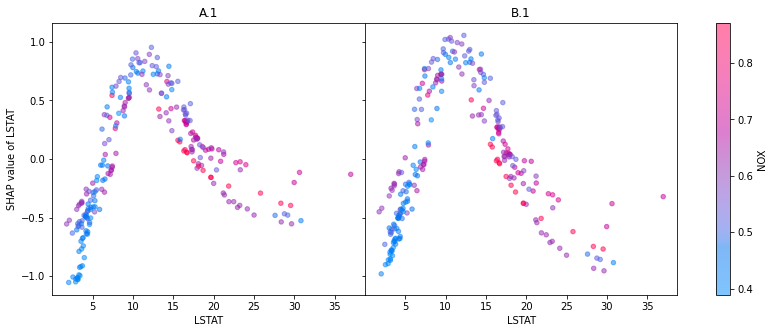

In [45]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.1'], 'LSTAT')
node.plot_feature_dependence('LSTAT', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

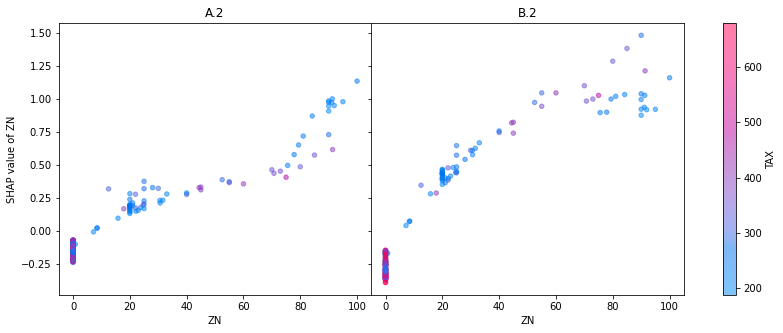

In [73]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'ZN')
node.plot_feature_dependence('ZN', classes=['A.2', 'B.2'], alpha=0.5,
                             color='TAX')

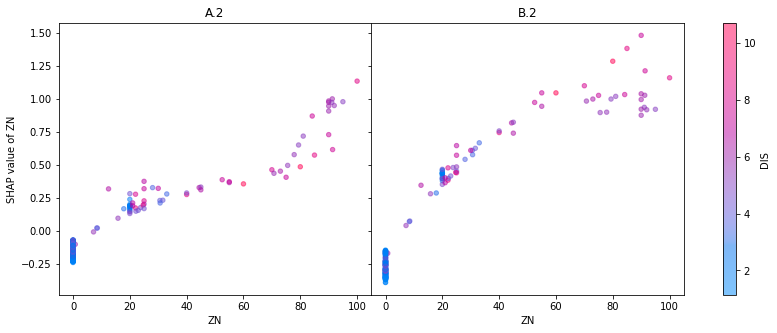

In [71]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'ZN')
node.plot_feature_dependence('ZN', classes=['A.2', 'B.2'], alpha=0.5,
                             color='DIS')

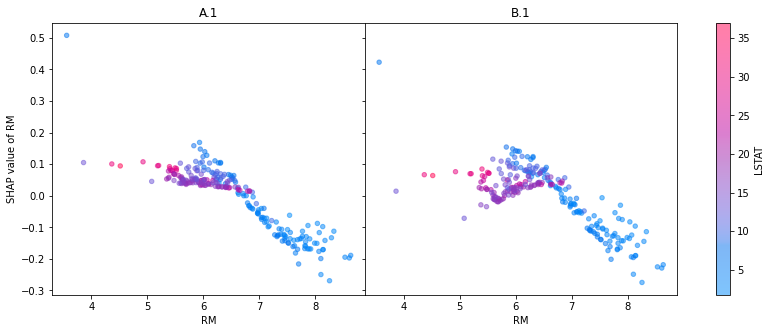

In [47]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.1'], 'RM')
node.plot_feature_dependence('RM', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

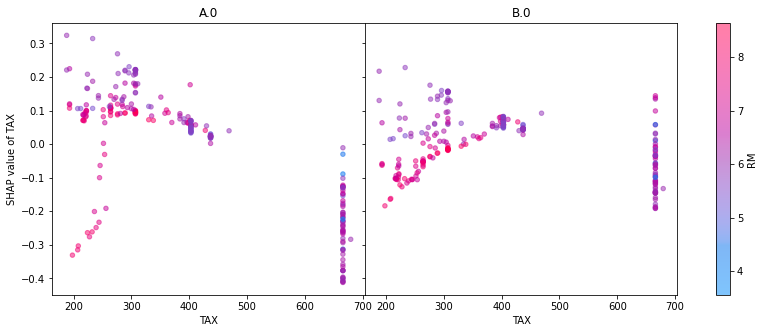

In [27]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.0'], 'TAX')
node.plot_feature_dependence('TAX', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

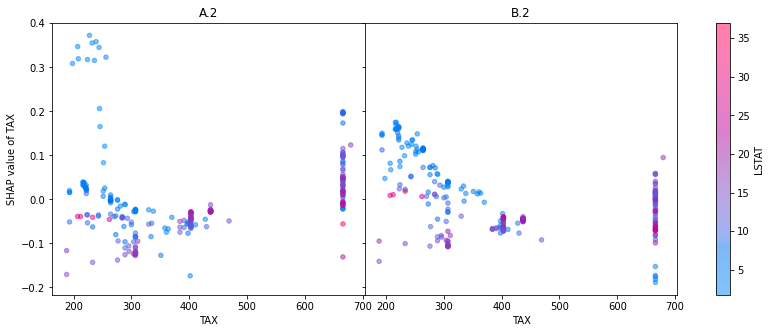

In [28]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'TAX')
node.plot_feature_dependence('TAX', classes=['A.2', 'B.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

The vertical spread in the dependence plots of DIS suggests that interactions are present, but more important it looks like the interactions cause different DIS effects.

The SHAP package can estimate interactions based on correlation.

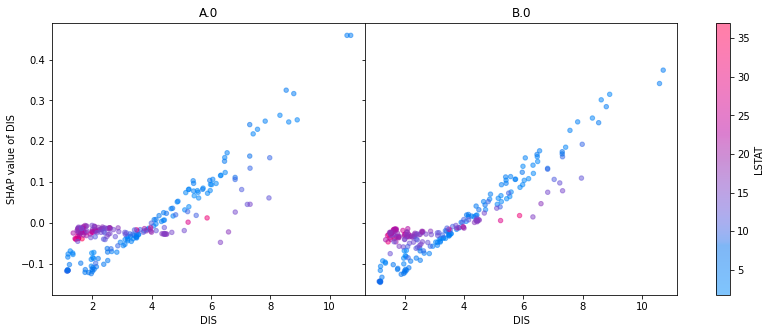

In [49]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.0'], 'DIS')
node.plot_feature_dependence('DIS', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

The strongest interactions are with feature LSTAT, clearly instances with medium to high LSTAT values yield different effects of feature DIS than with low values.

For AGE too, LSTAT mainly accounts for the vertical spread.

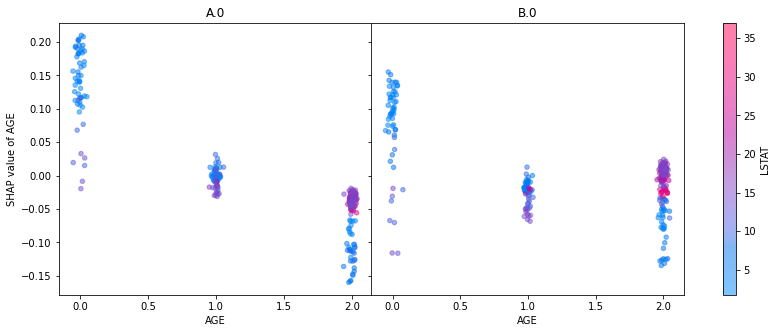

In [26]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.0'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

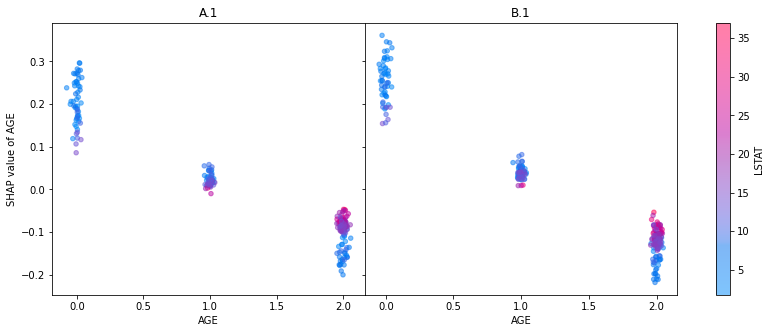

In [27]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.1'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

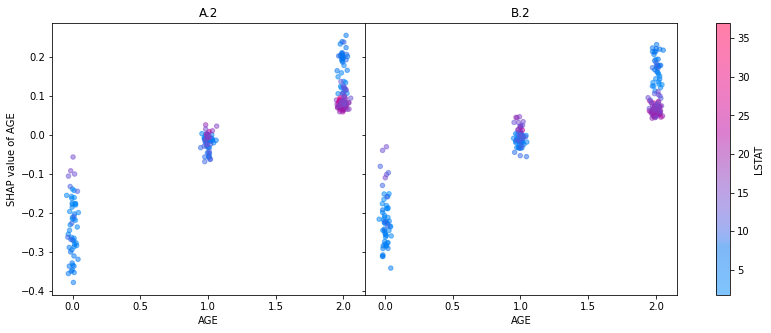

In [28]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'B.2'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.2', 'B.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

# Difference Classifier Explanations

In [7]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

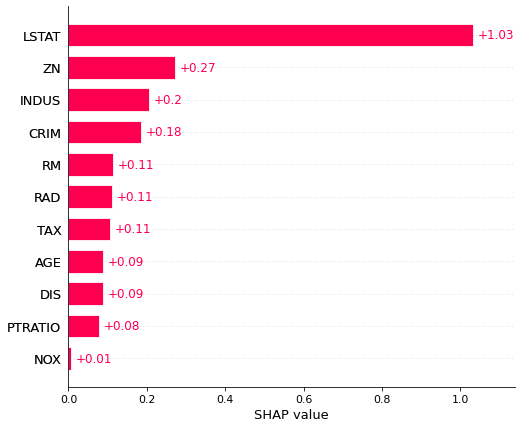

In [8]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## $(0,1)$

In [16]:
node = load('(0, 1)')
node.class_counts, node.distance
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']

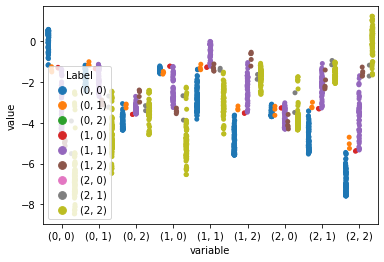

In [17]:
node.plot_outcomes()

### Main Node (LRR)

In [18]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRR,
 (1, 1)    17
 (0, 0)     8
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 21.950278876066292)

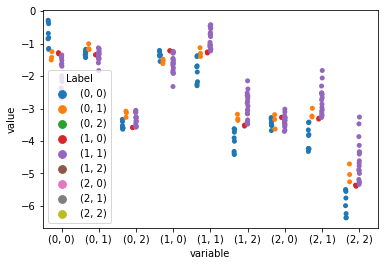

In [14]:
node.plot_outcomes()

11.1 <= LSTAT <= 14.19
[Lower CF: LSTAT == 10.48 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 14.9 --> {'(0, 0)': 3}]


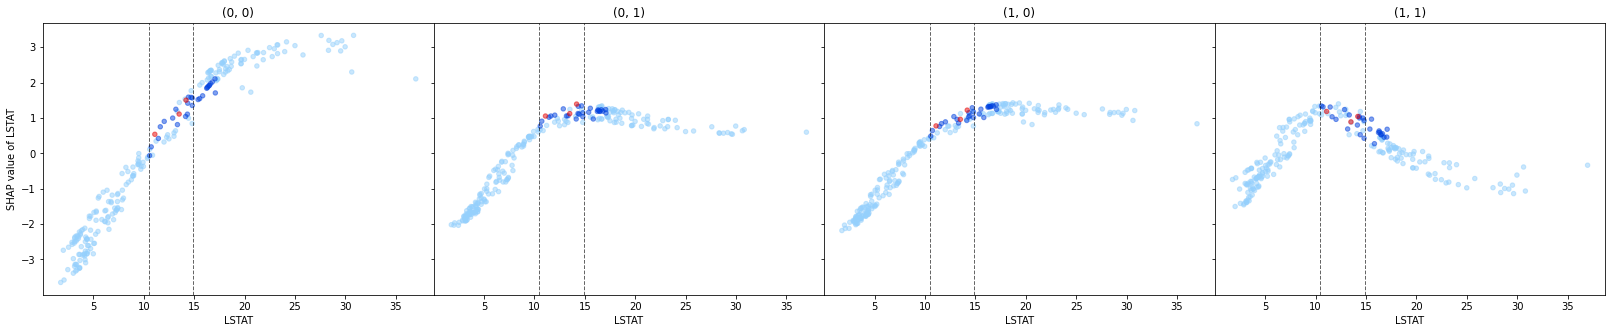

ZN == 0.0
[Upper CF: ZN == 2.0 --> {'(1, 1)': 3}]


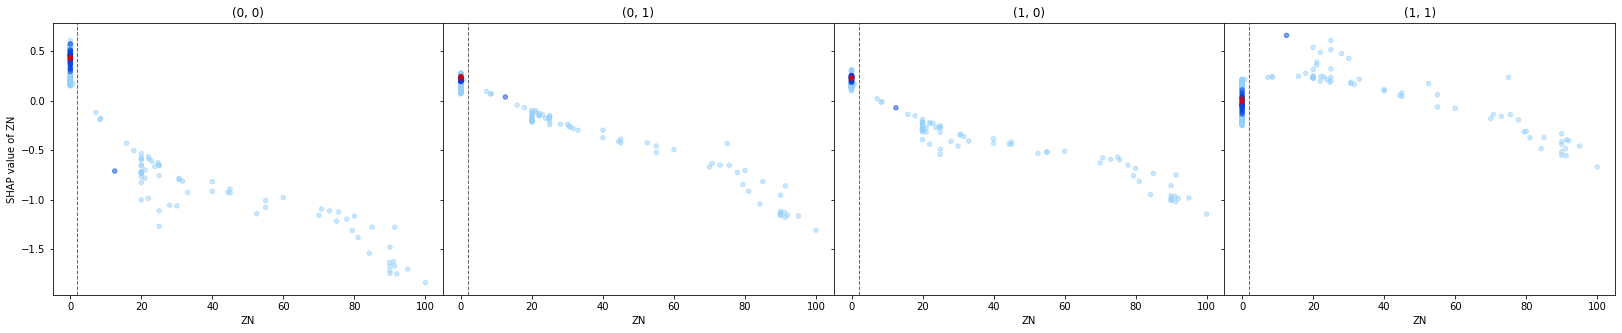

13.89 <= INDUS <= 19.58
[Lower CF: INDUS == 12.37 --> {'(1, 1)': 3},
 Upper CF: INDUS == 22.11 --> {'(0, 0)': 3}]


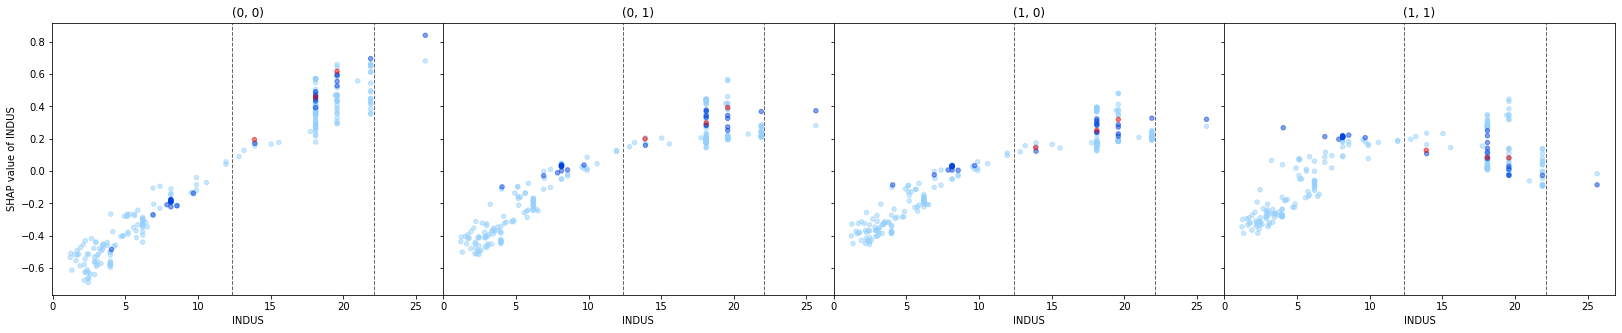

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 4.4 --> {'(0, 0)': 3}]


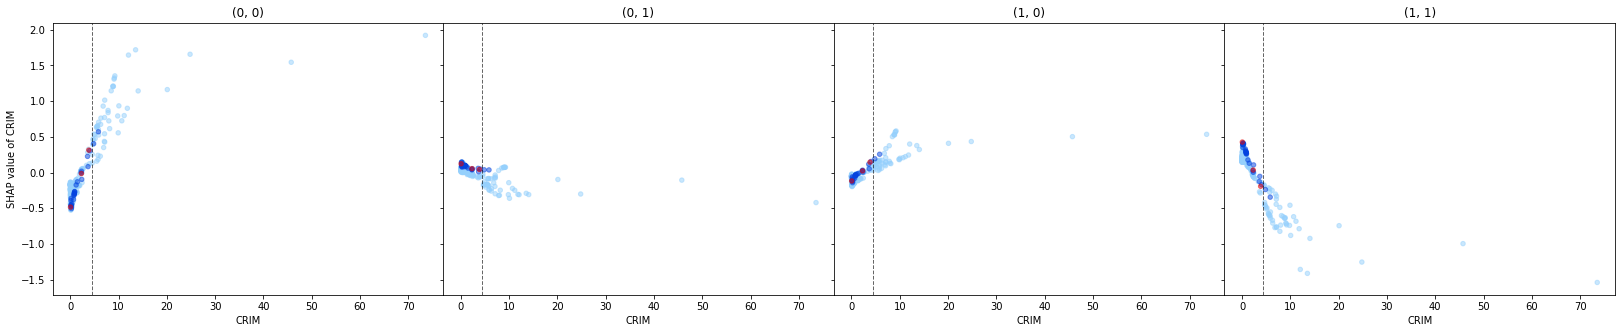

5.888 <= RM <= 6.319
[Lower CF: RM == 4.81 --> {'(0, 0)': 3}, Upper CF: RM == 7.34 --> {'(1, 1)': 3}]


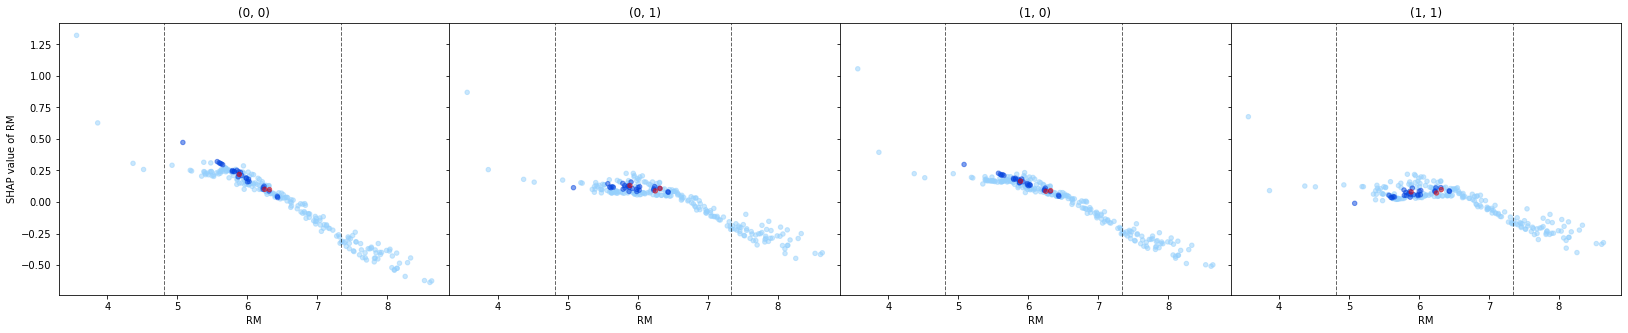

5.0 <= RAD
[]


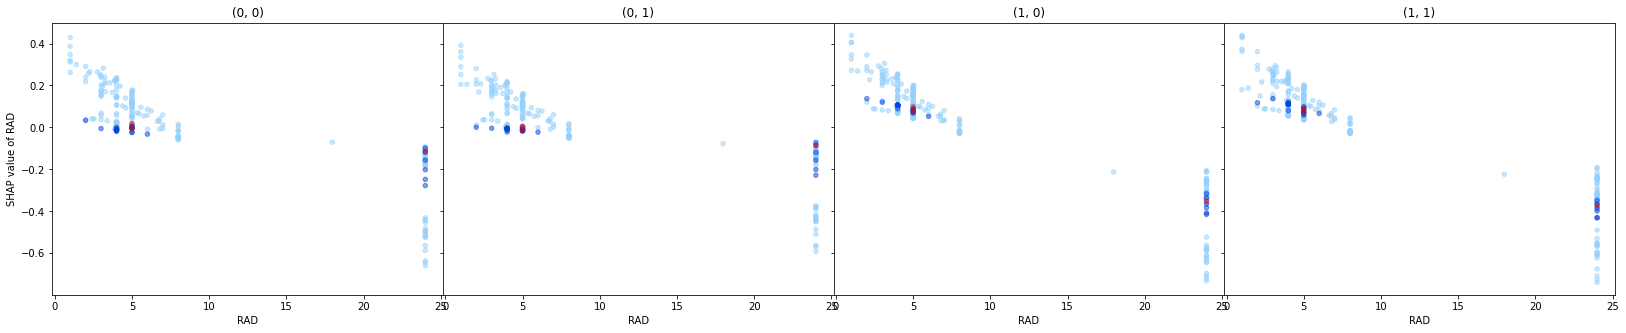

276.0 <= TAX <= 666.0
[]


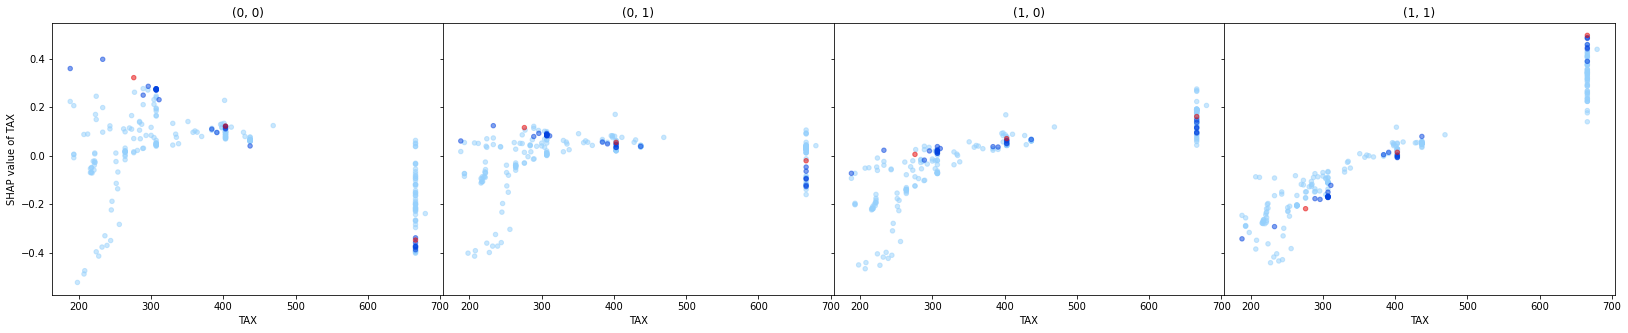

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 1)': 3}]


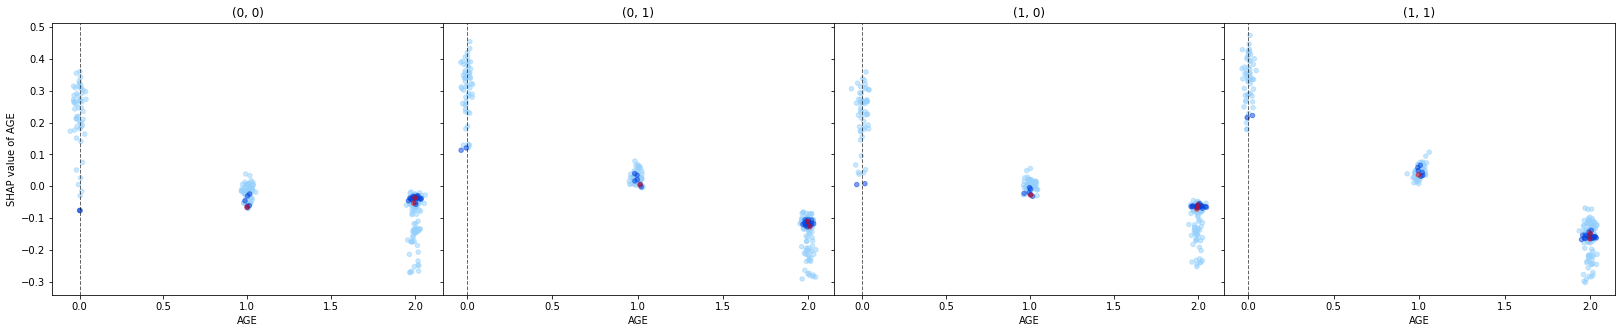

2.1 <= DIS <= 3.1121
[Upper CF: DIS == 6.6 --> {'(1, 1)': 3}]


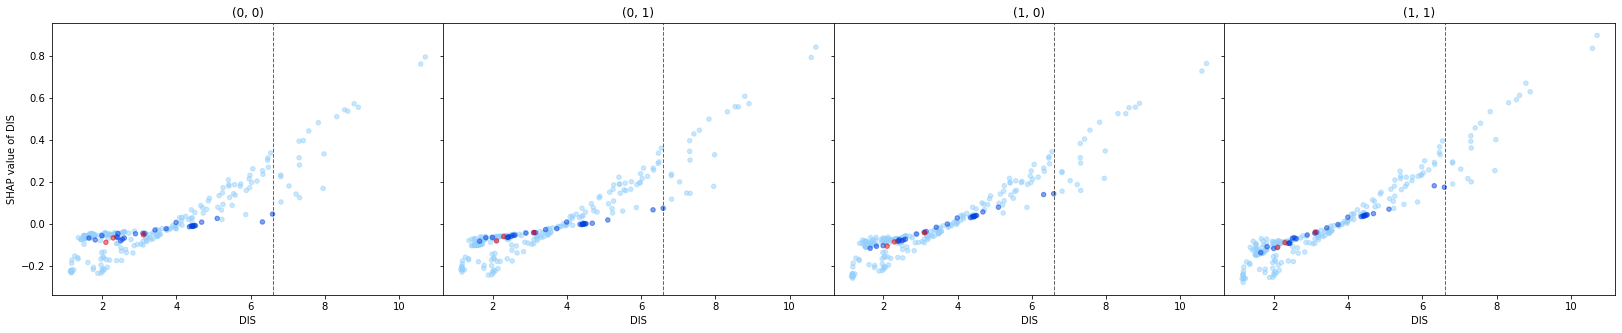

14.7 <= PTRATIO <= 20.2
[Lower CF: PTRATIO == 13.36 --> {'(0, 0)': 3},
 Upper CF: PTRATIO == 20.74 --> {'(1, 1)': 3}]


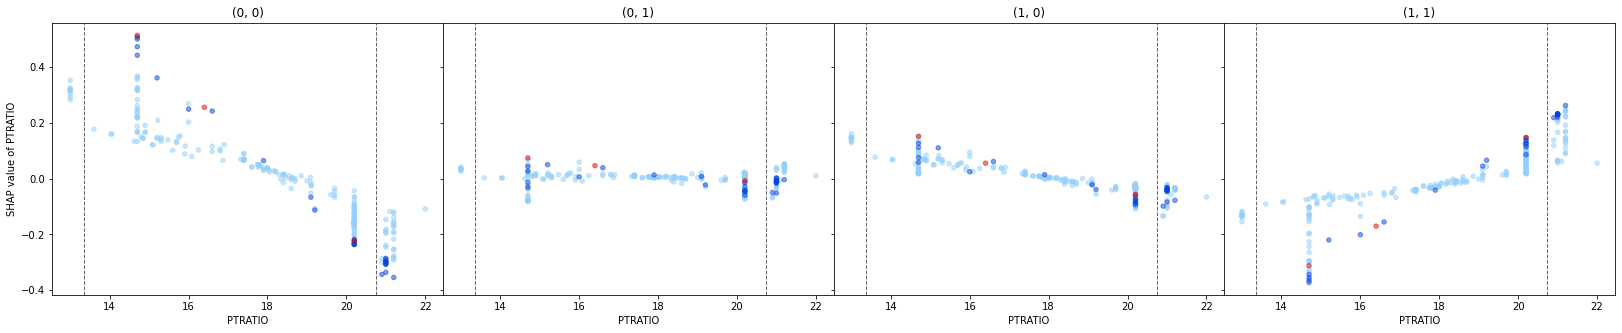

0.55 <= NOX <= 0.77
[]


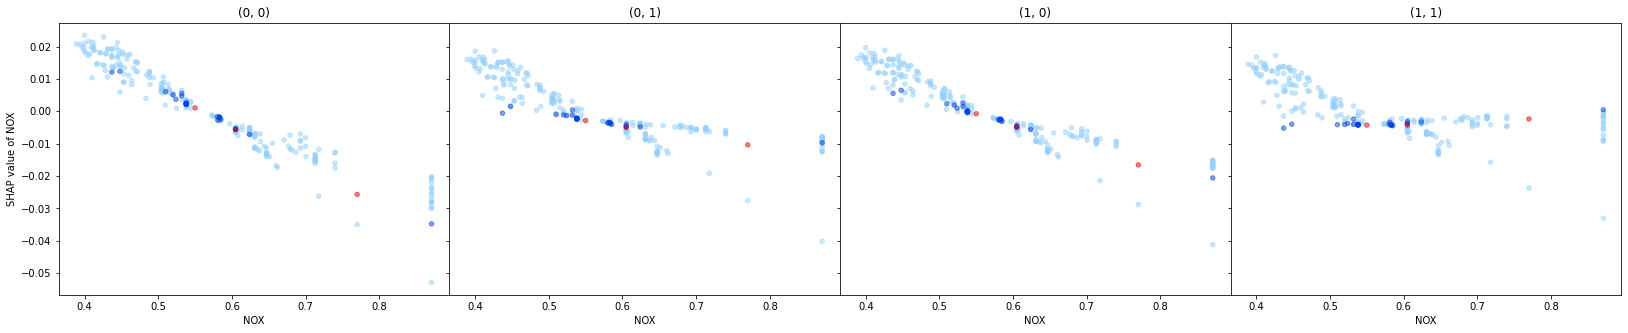

In [20]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)

### Node 1 (LRRLR)

In [21]:
path = [node]
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRLR,
 (1, 1)    3
 (0, 1)    2
 (0, 0)    2
 dtype: int64,
 6.409084583236691)

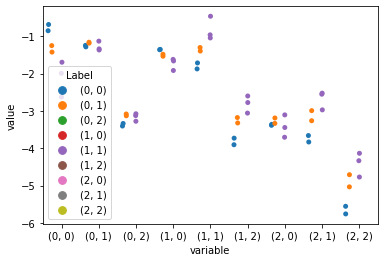

In [22]:
node.plot_outcomes()

11.1 <= LSTAT <= 14.19
[Lower CF: LSTAT == 10.48 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 14.9 --> {'(0, 0)': 3}]


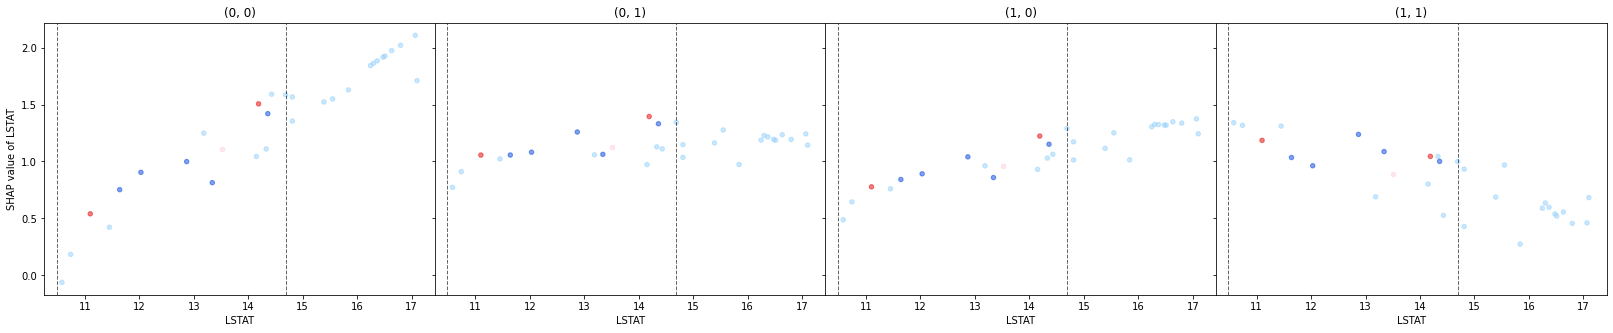

13.89 <= INDUS <= 19.58
[Lower CF: INDUS == 12.37 --> {'(1, 1)': 3},
 Upper CF: INDUS == 22.11 --> {'(0, 0)': 3}]


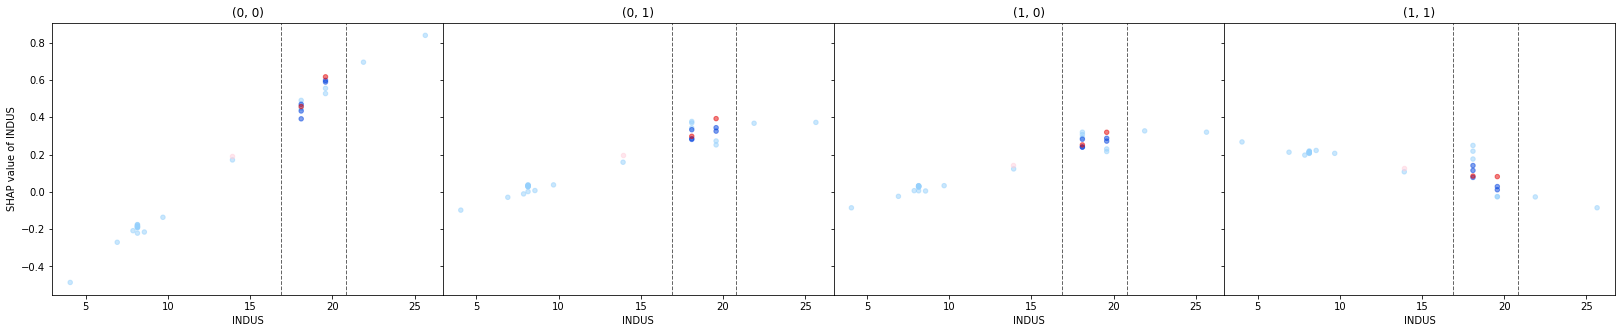

ZN == 0.0
[Upper CF: ZN == 2.0 --> {'(1, 1)': 3}]


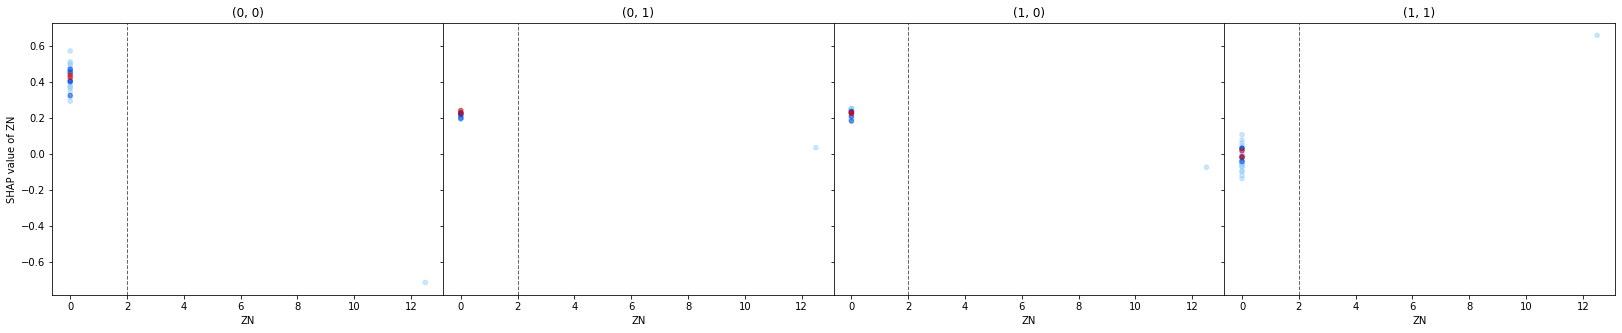

14.7 <= PTRATIO <= 20.2
[Lower CF: PTRATIO == 13.36 --> {'(0, 0)': 3},
 Upper CF: PTRATIO == 20.74 --> {'(1, 1)': 3}]


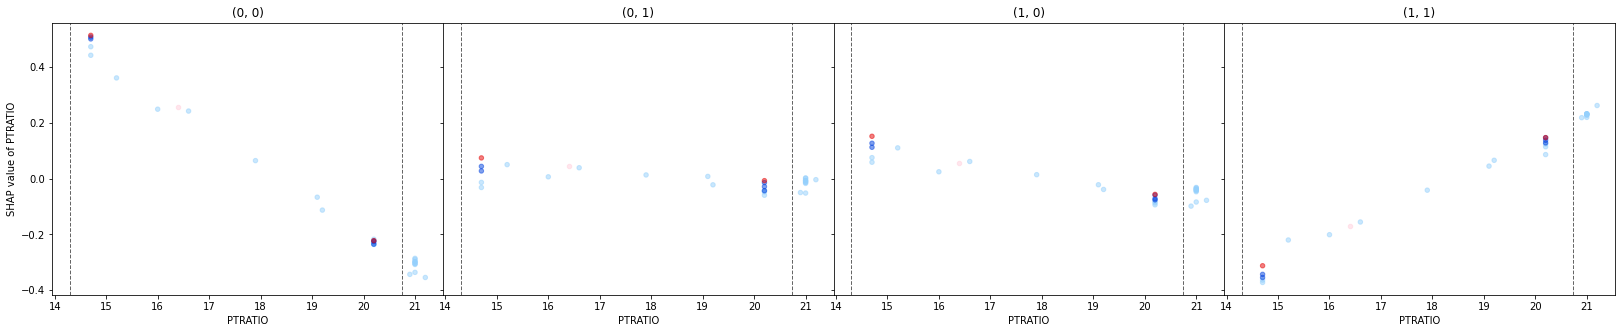

276.0 <= TAX <= 666.0
[]


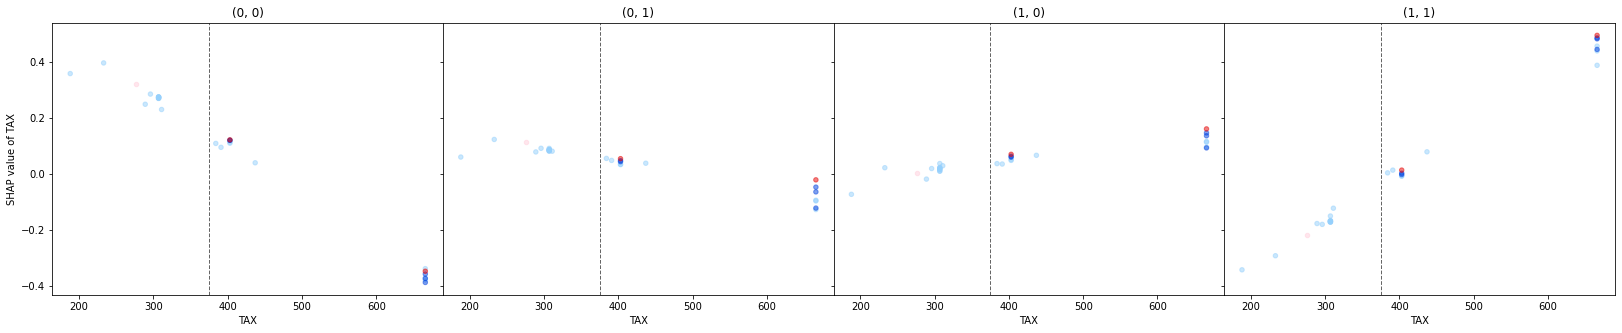

5.0 <= RAD
[]


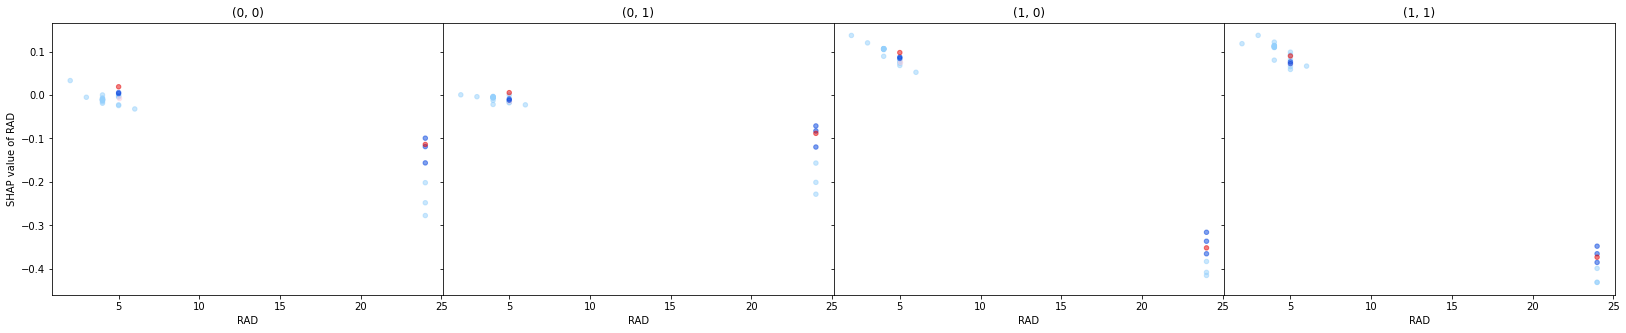

5.888 <= RM <= 6.319
[Lower CF: RM == 4.81 --> {'(0, 0)': 3}, Upper CF: RM == 7.34 --> {'(1, 1)': 3}]


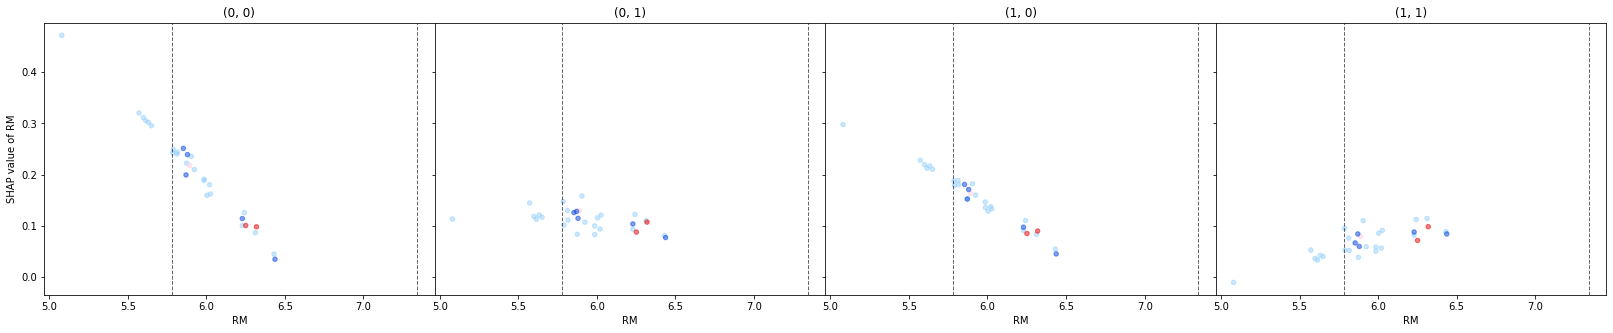

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 4.4 --> {'(0, 0)': 3}]


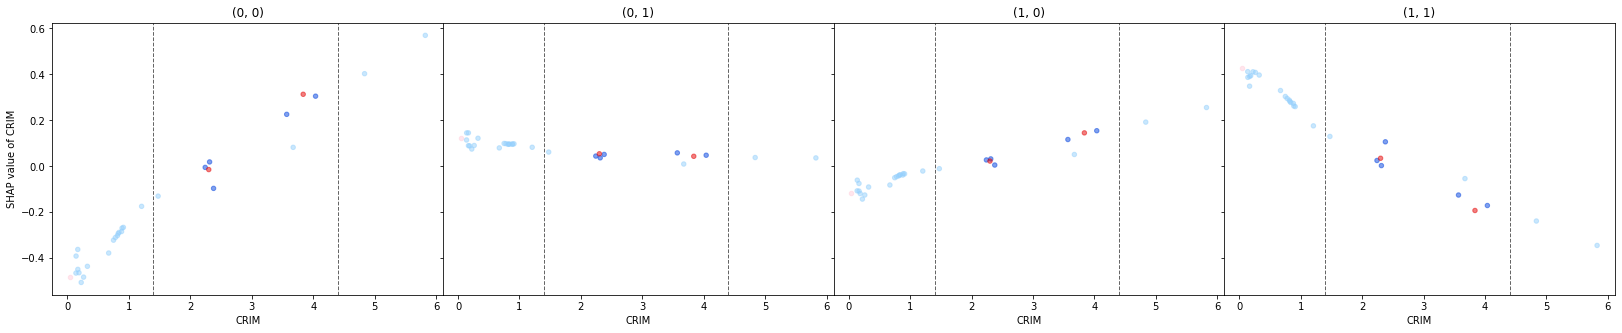

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 1)': 3}]


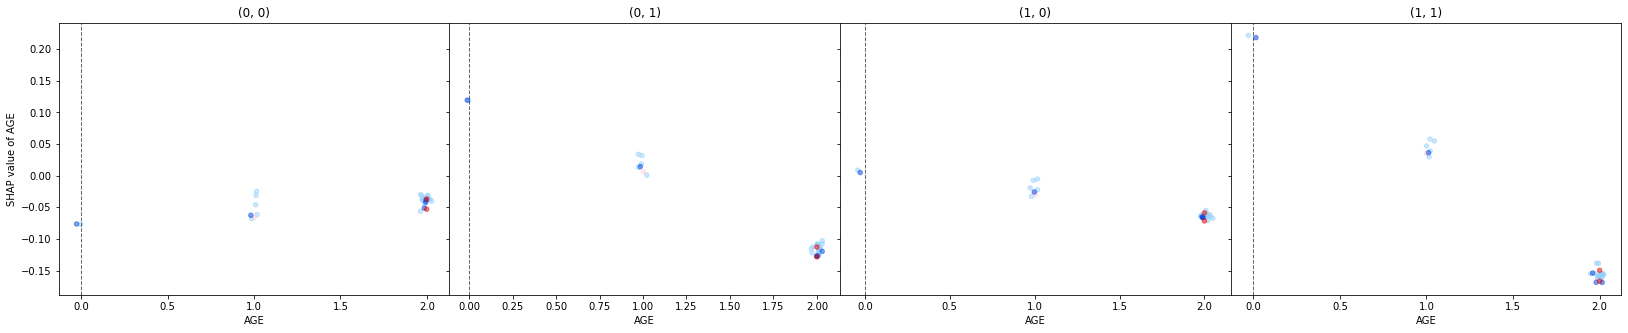

In [27]:
path[-1].plot_feature_dependence(*node.features_ordered[:-2], focus=node, classes=classes, print_stats=True)

### Node 2 (LRRRRRRL)

In [28]:
node = path[-1].right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRRRRRLR,
 (0, 1)    1
 dtype: int64,
 0)

In [30]:
node = node.parent
node, node.class_counts, node.distance

(LRRRRRRL,
 (0, 1)    1
 (1, 1)    1
 dtype: int64,
 0.9851516776062743)

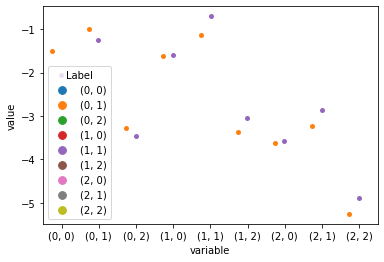

In [31]:
node.plot_outcomes()

11.1 <= LSTAT <= 14.19
[Lower CF: LSTAT == 10.48 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 14.9 --> {'(0, 0)': 3}]


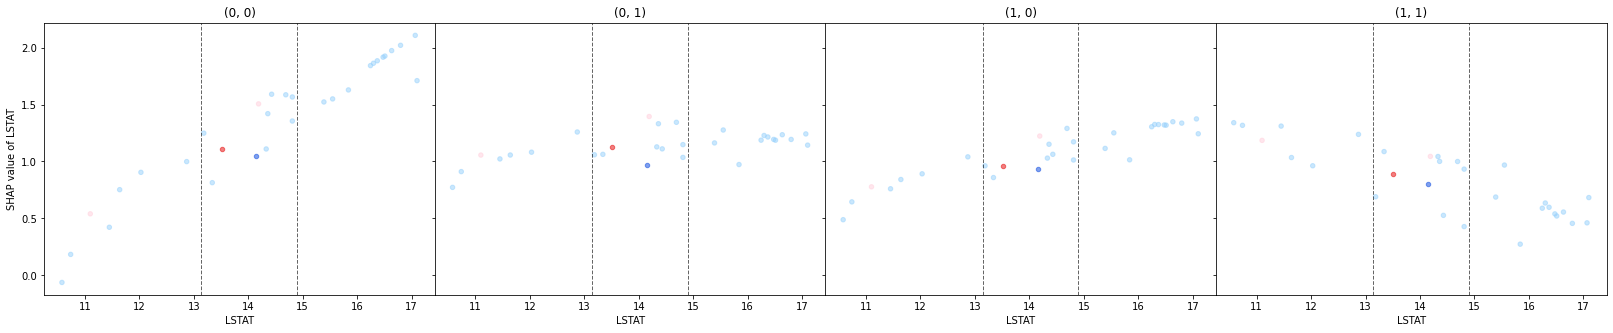

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 4.4 --> {'(0, 0)': 3}]


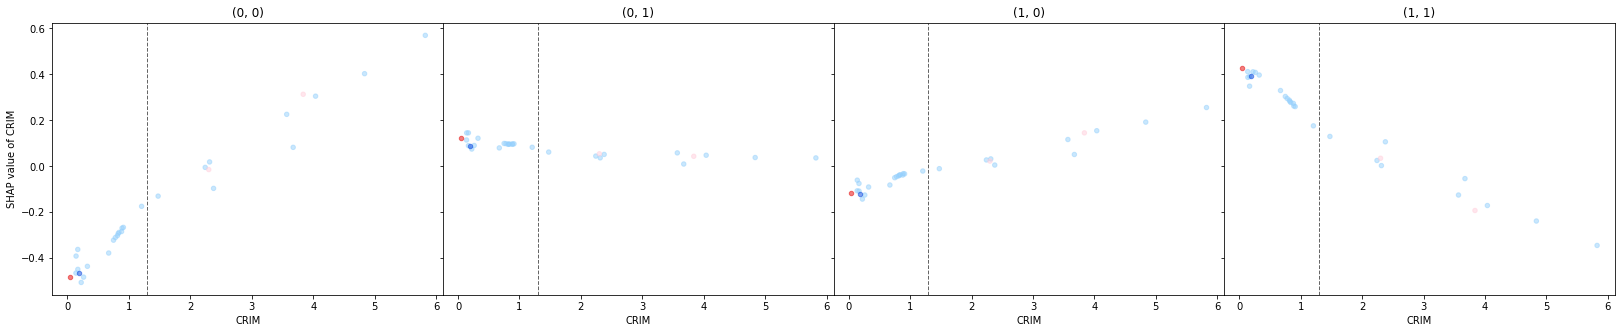

ZN == 0.0
[Upper CF: ZN == 2.0 --> {'(1, 1)': 3}]


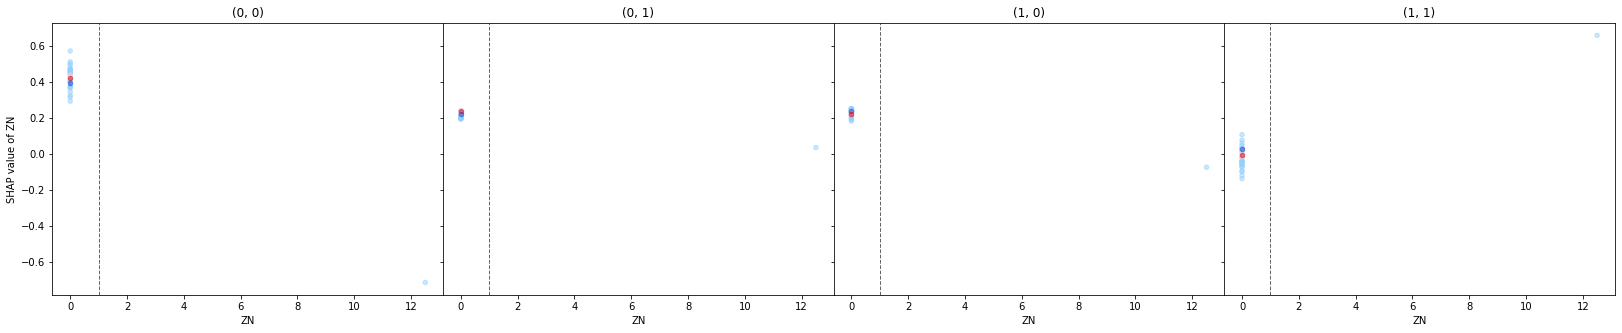

276.0 <= TAX <= 666.0
[]


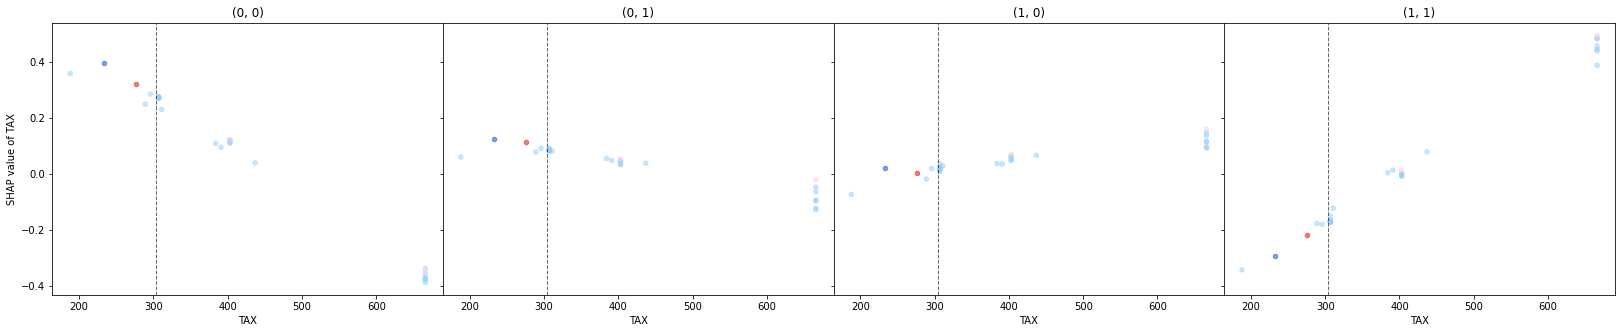

13.89 <= INDUS <= 19.58
[Lower CF: INDUS == 12.37 --> {'(1, 1)': 3},
 Upper CF: INDUS == 22.11 --> {'(0, 0)': 3}]


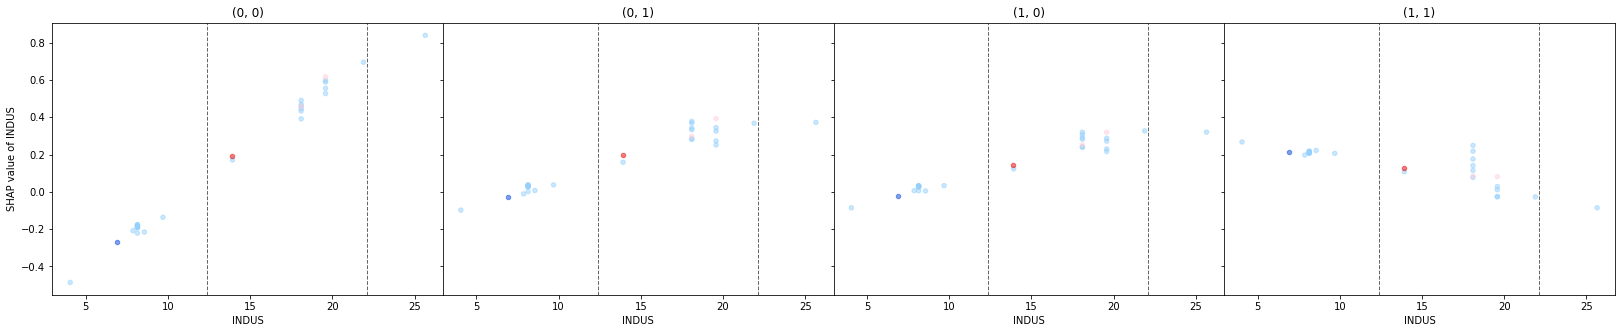

5.888 <= RM <= 6.319
[Lower CF: RM == 4.81 --> {'(0, 0)': 3}, Upper CF: RM == 7.34 --> {'(1, 1)': 3}]


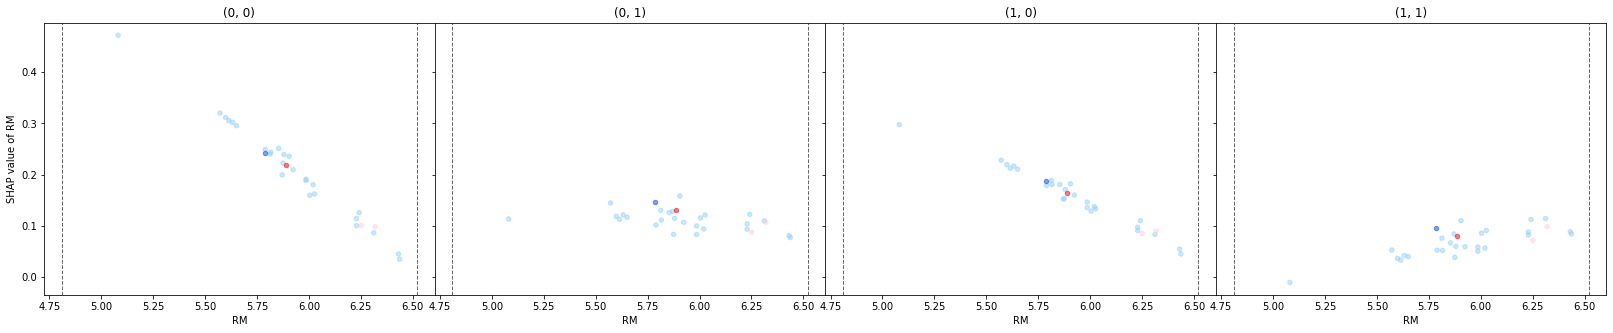

14.7 <= PTRATIO <= 20.2
[Lower CF: PTRATIO == 13.36 --> {'(0, 0)': 3},
 Upper CF: PTRATIO == 20.74 --> {'(1, 1)': 3}]


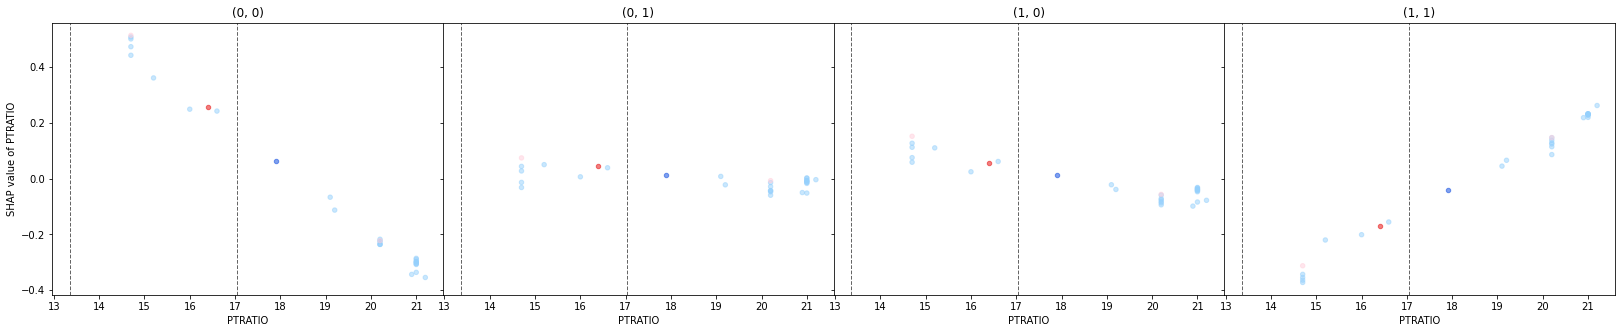

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 1)': 3}]


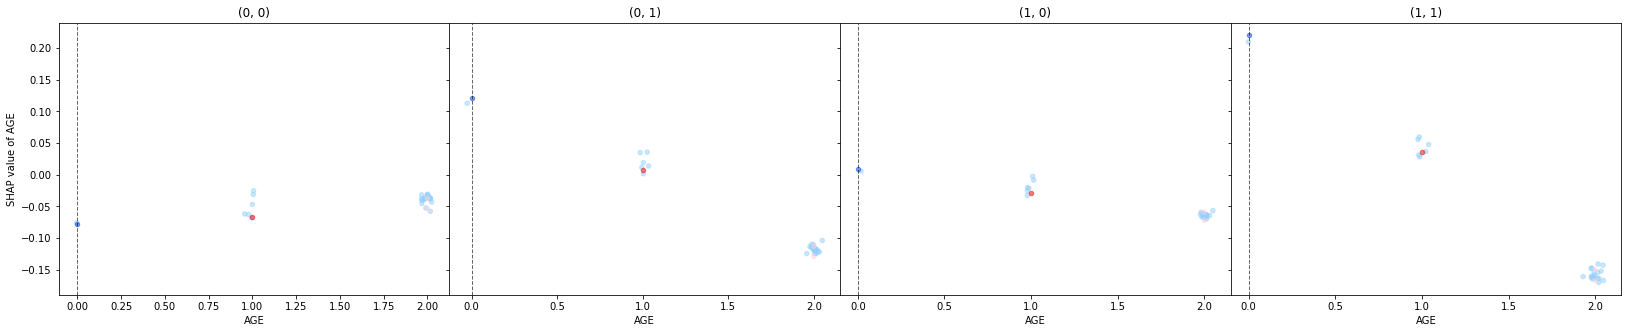

5.0 <= RAD
[]


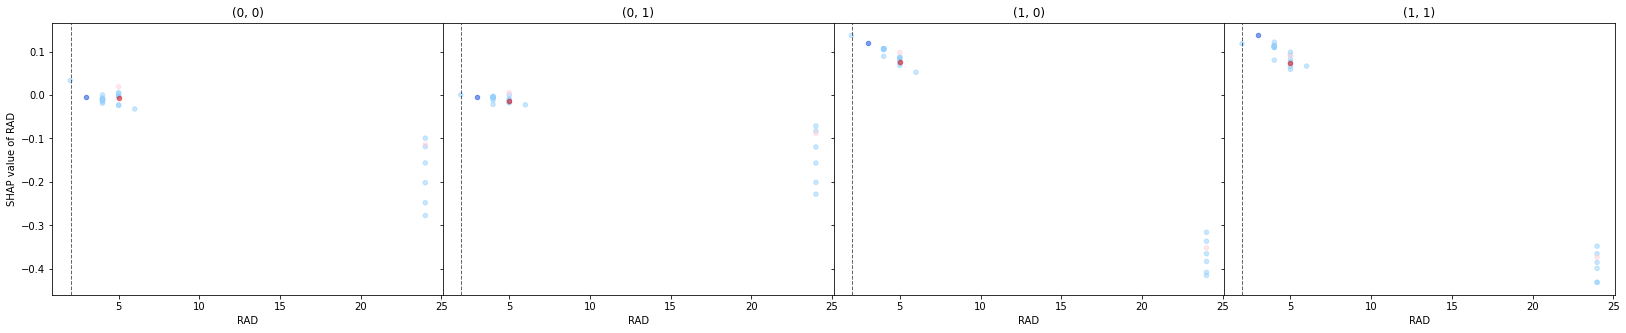

In [33]:
path[-1].plot_feature_dependence(*node.features_ordered[:-2], focus=node, classes=classes, print_stats=True)

## $(1,0)$

In [36]:
node = load('(1, 0)')
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 149.33968539846273)

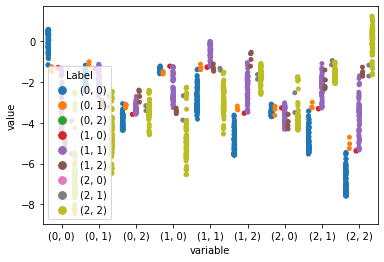

In [35]:
node.plot_outcomes()

### Main Node (LRRRRRLRRL)

In [37]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRRRRLRRLR,
 (1, 0)    2
 dtype: int64,
 0.001899920368762976)

In [38]:
node = node.parent
node, node.class_counts, node.distance

(LRRRRRLRRL,
 (1, 0)    2
 (1, 1)    1
 dtype: int64,
 0.03131691911091533)

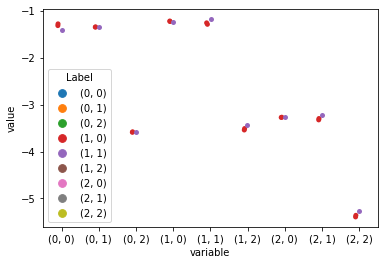

In [39]:
node.plot_outcomes()

16.476581495471024 <= LSTAT <= 16.51
[Lower CF: LSTAT == 16.33 --> {'(1, 1)': 2},
 Upper CF: LSTAT == 16.72 --> {'(0, 0)': 2}]


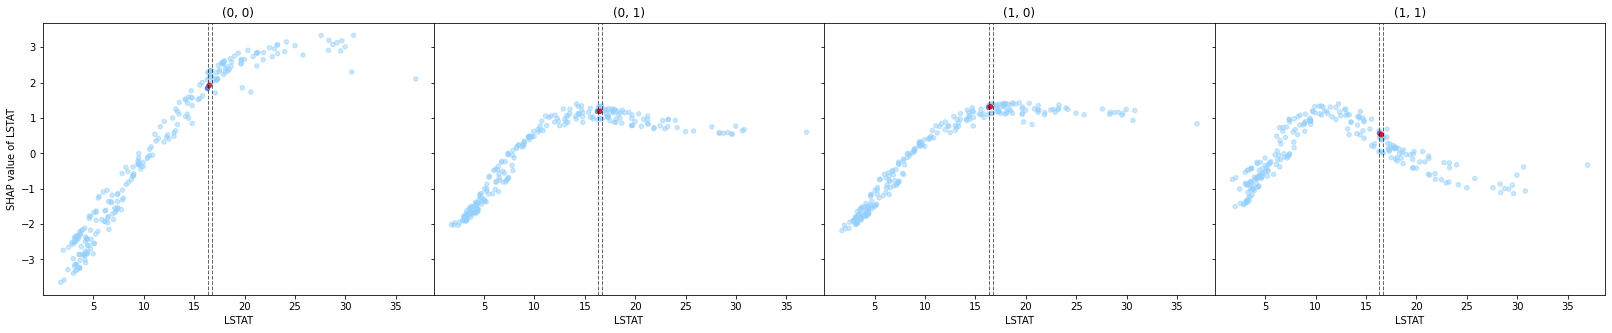

ZN == 0.0
[Upper CF: ZN == 1.0 --> {'(1, 1)': 2}]


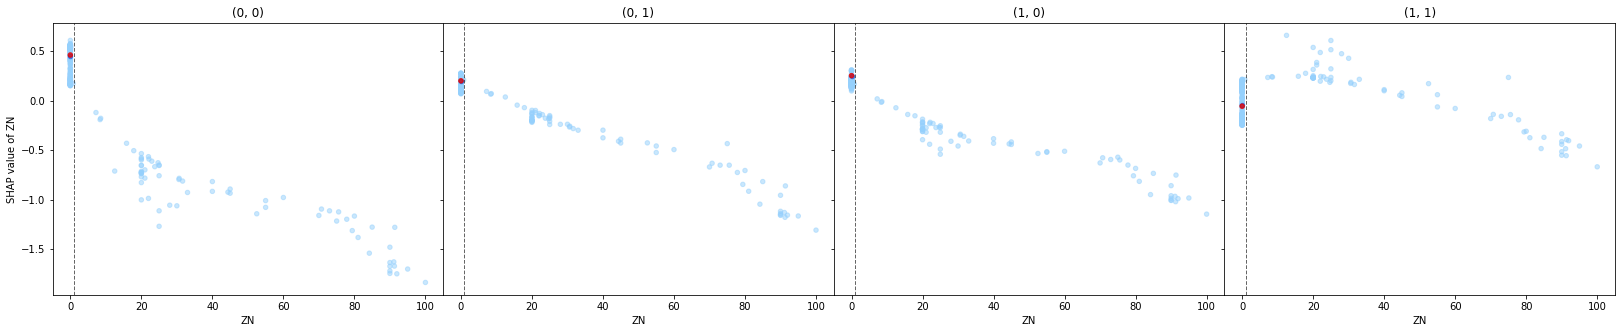

INDUS == 8.14
[Lower CF: INDUS == 7.13 --> {'(1, 1)': 2},
 Upper CF: INDUS == 9.15 --> {'(0, 0)': 2}]


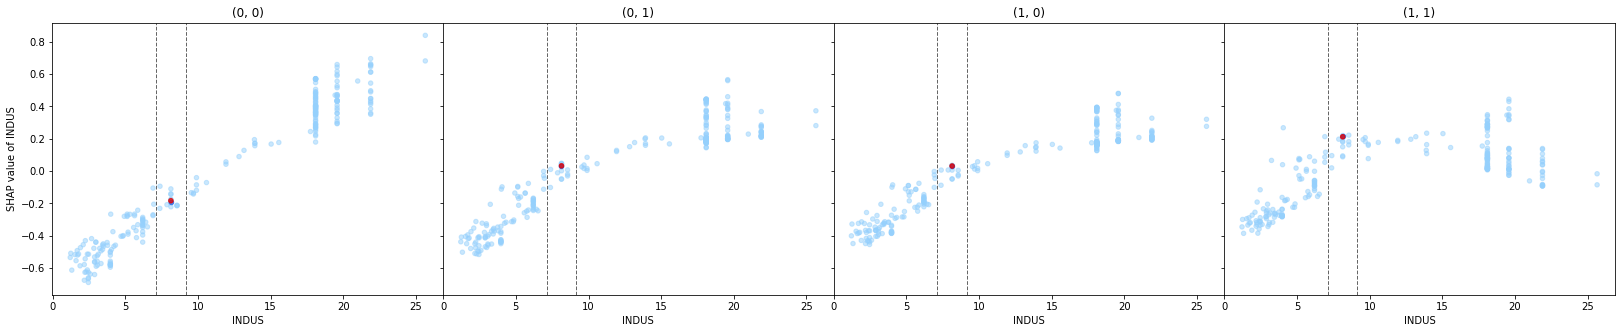

0.8261732257672565 <= CRIM <= 0.84054
[Lower CF: CRIM == 0.6 --> {'(1, 1)': 2},
 Upper CF: CRIM == 1.2 --> {'(0, 0)': 2}]


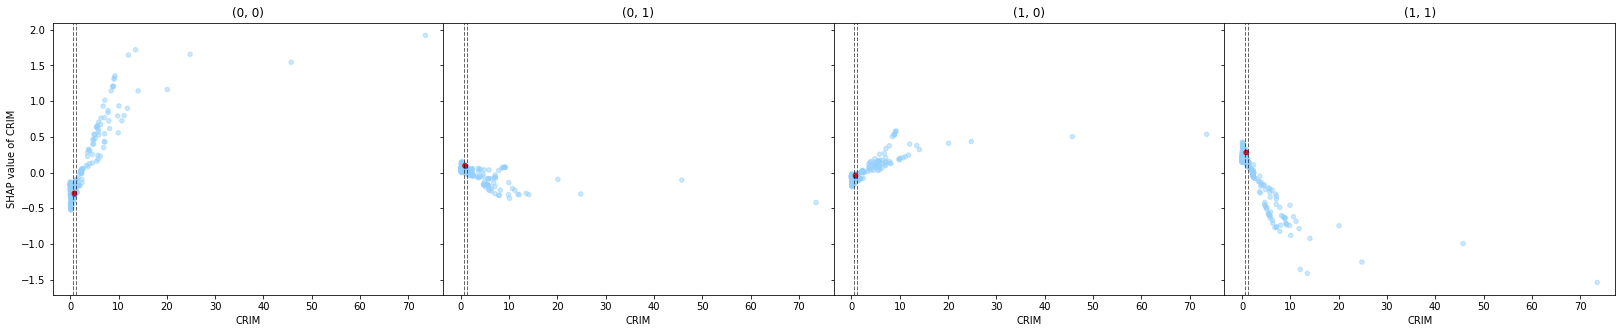

5.599 <= RM <= 5.65071911415199
[Lower CF: RM == 5.22 --> {'(0, 0)': 2}, Upper CF: RM == 5.76 --> {'(1, 1)': 2}]


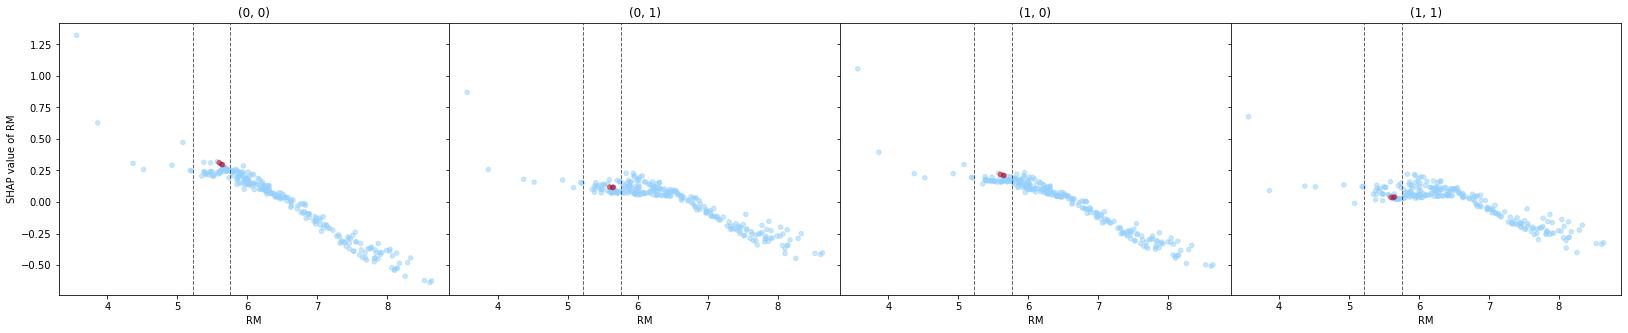

RAD == 4.0
[Upper CF: RAD == 5.94 --> {'(0, 0)': 2}]


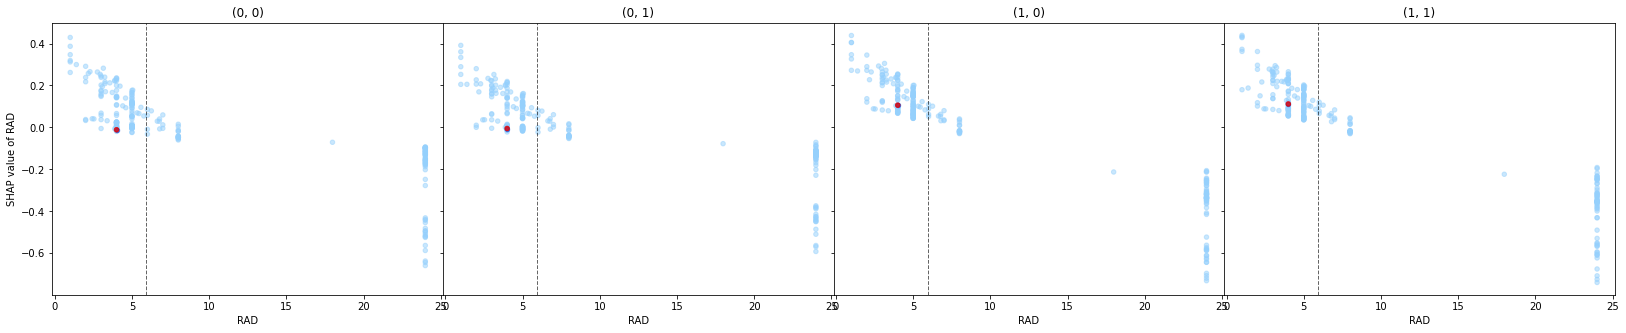

TAX == 307.0
[Lower CF: TAX == 288.0 --> {'(0, 0)': 2},
 Upper CF: TAX == 327.0 --> {'(1, 1)': 2}]


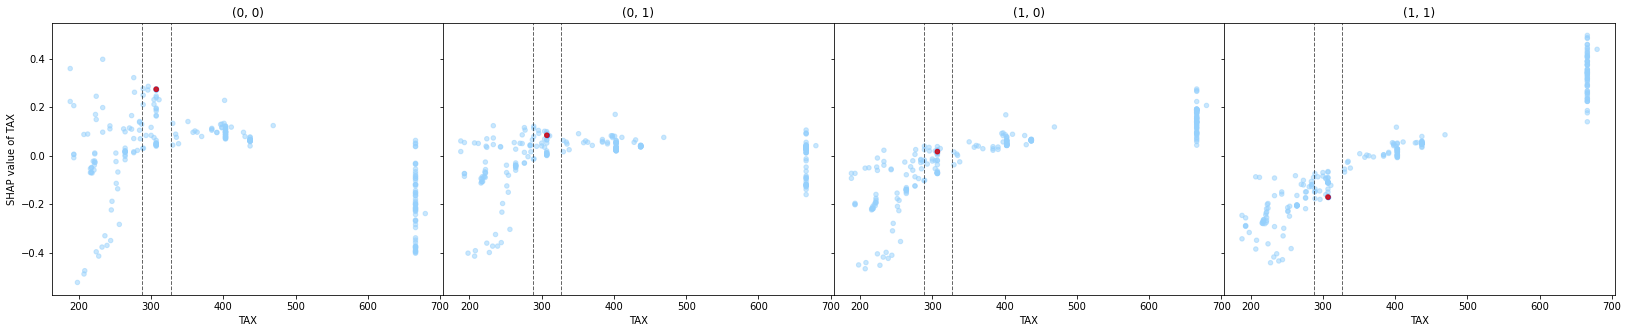

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 2}]


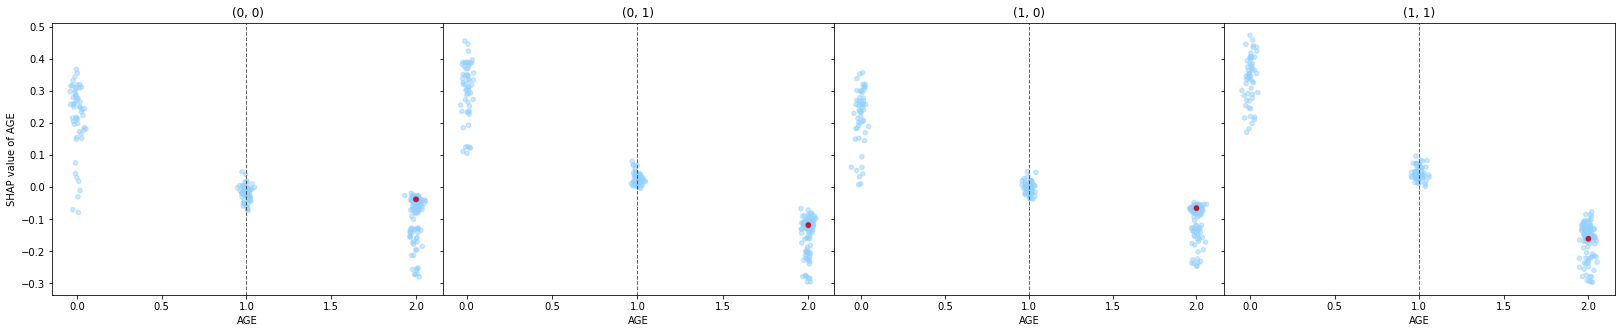

4.4458475345281245 <= DIS <= 4.4546
[Lower CF: DIS == 2.93 --> {'(1, 1)': 1, '(0, 0)': 1}]


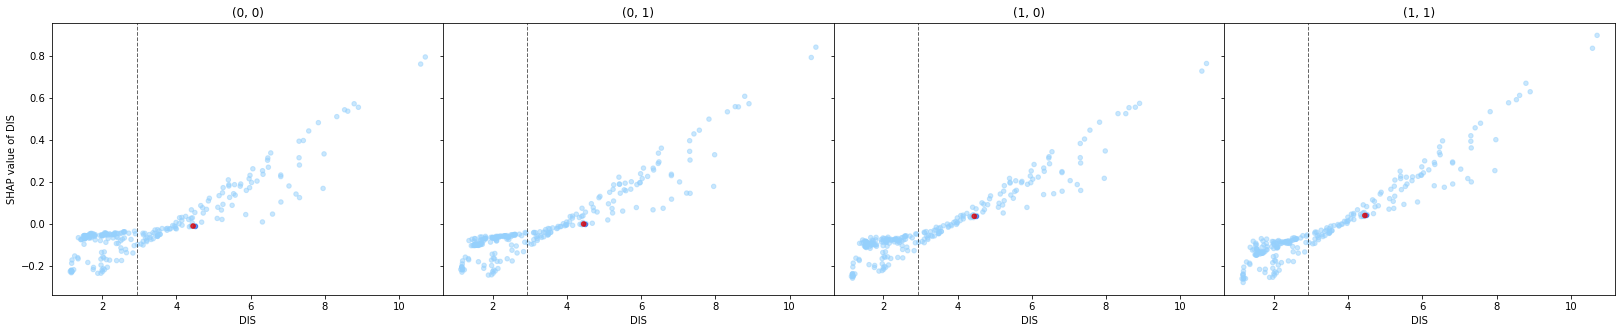

PTRATIO == 21.0
[Lower CF: PTRATIO == 20.58 --> {'(0, 0)': 2},
 Upper CF: PTRATIO == 21.39 --> {'(1, 1)': 2}]


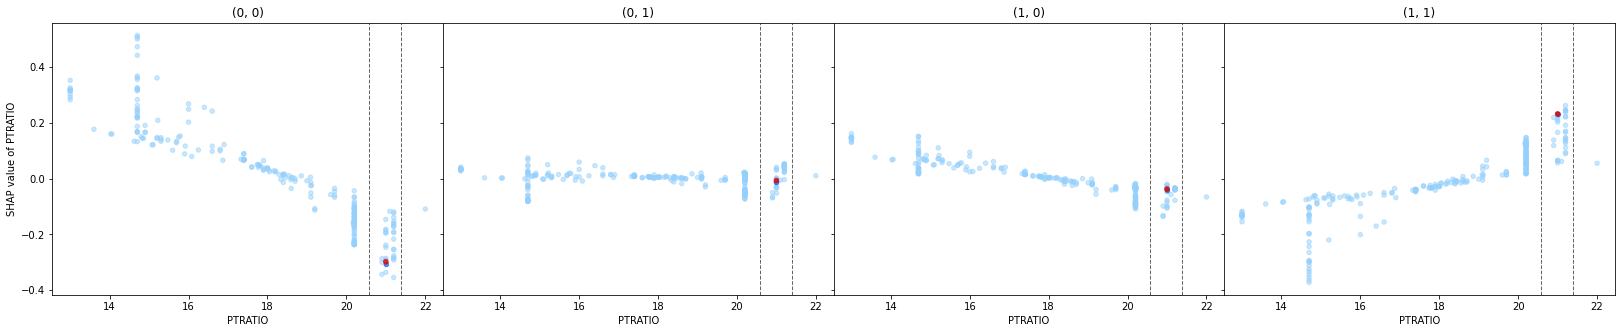

NOX == 0.538
[]


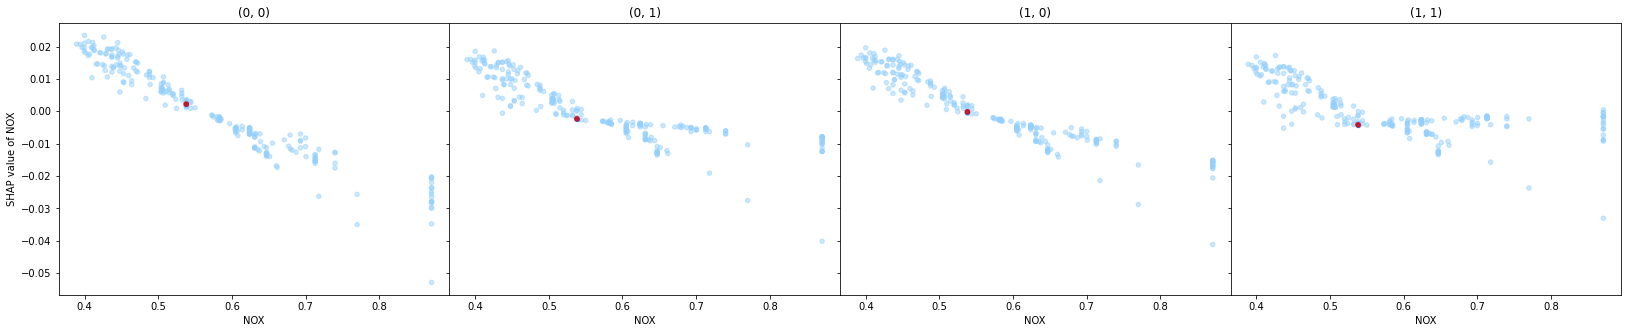

In [40]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)

## $(1,2)$

In [41]:
node = load('(1, 2)')
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 149.33968539846273)

### Main Node (LRRRRRLRRL)

In [42]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(R,
 (2, 2)    96
 (1, 1)    35
 (1, 2)     5
 (2, 1)     2
 dtype: int64,
 80.73292334198608)

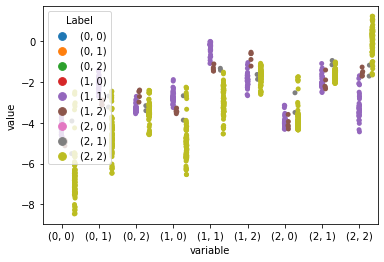

In [43]:
node.plot_outcomes()

5.49 <= LSTAT <= 9.522242201272585
[Lower CF: LSTAT == 3.58 --> {'(2, 2)': 5},
 Upper CF: LSTAT == 11.59 --> {'(1, 1)': 5}]


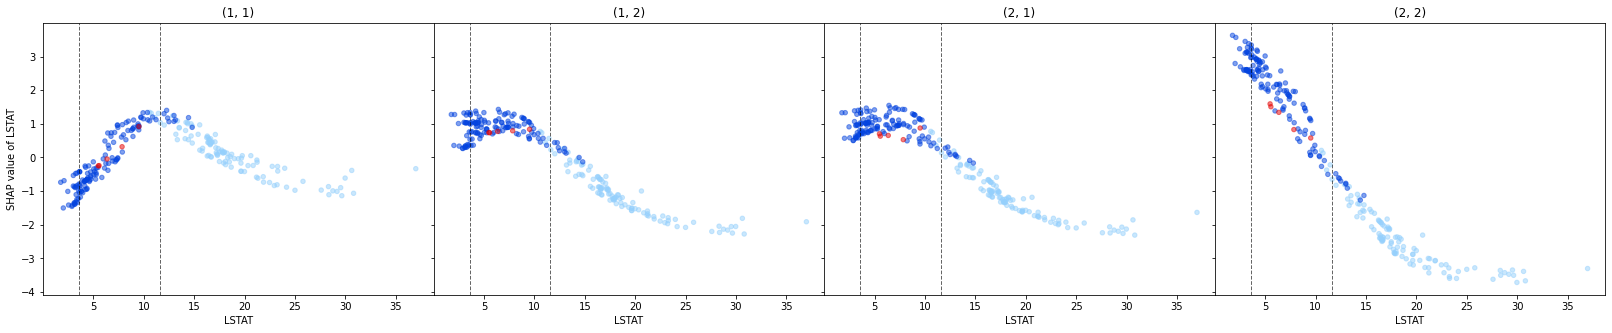

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 5}]


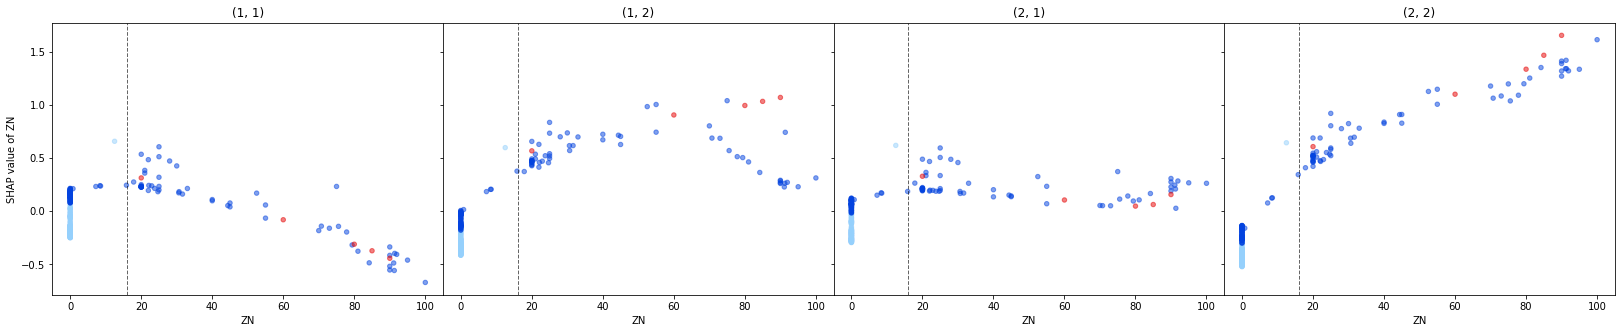

1.69 <= INDUS <= 4.15
[Upper CF: INDUS == 16.13 --> {'(1, 1)': 5}]


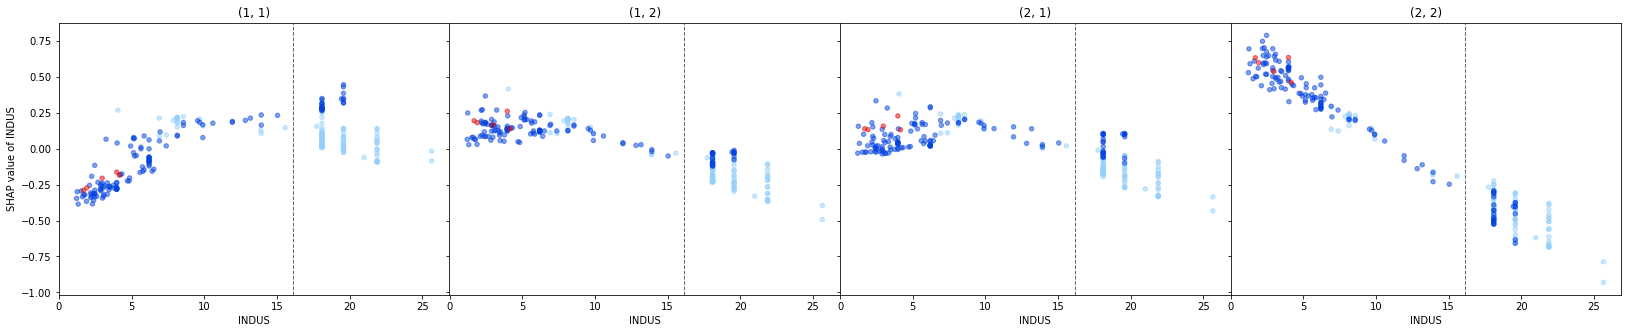

CRIM <= 0.539742303467232
[Upper CF: CRIM == 42.4 --> {'(2, 2)': 3, '(0, 0)': 1, '(1, 0)': 1}]


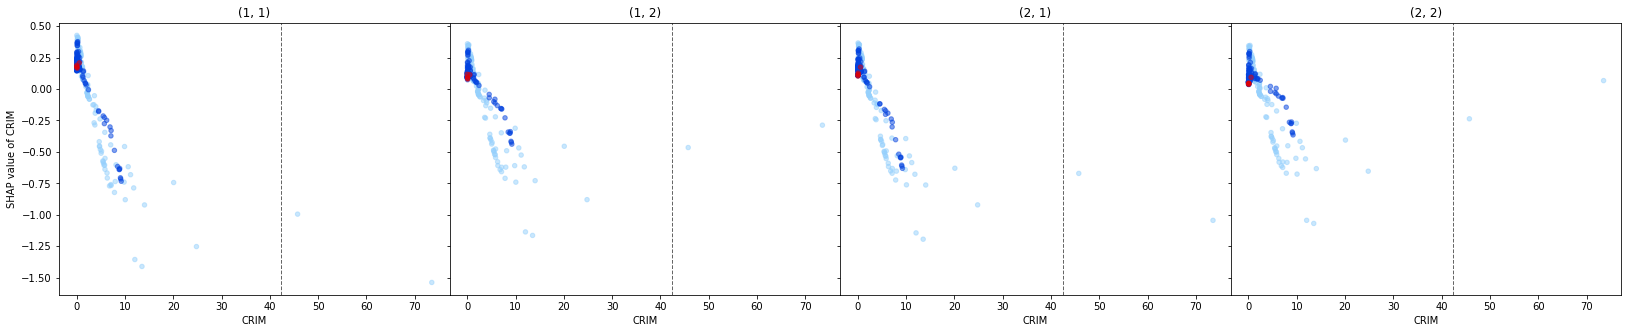

5.936 <= RM <= 7.225002872141104
[Upper CF: RM == 8.64 --> {'(2, 2)': 5}]


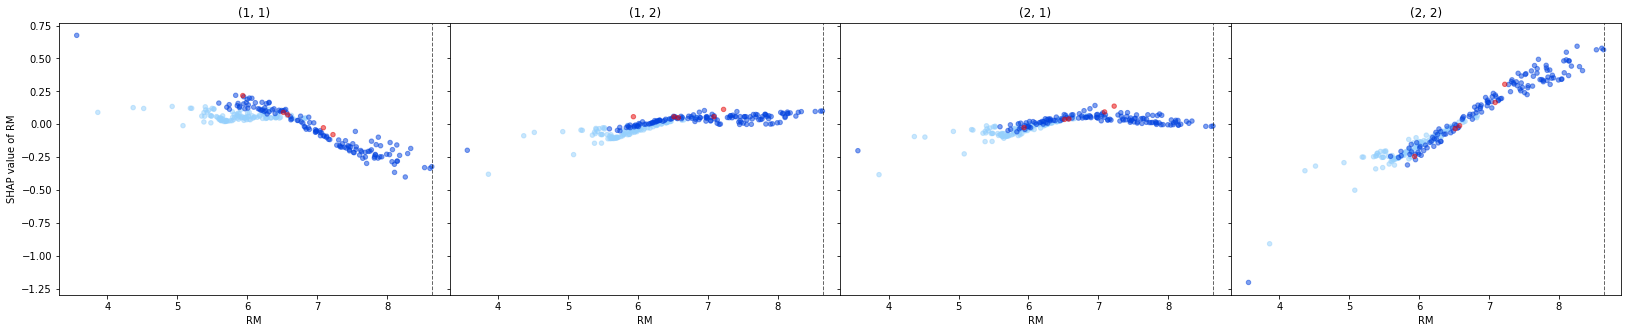

RAD <= 5.0
[Upper CF: RAD == 13.36 --> {'(2, 2)': 5}]


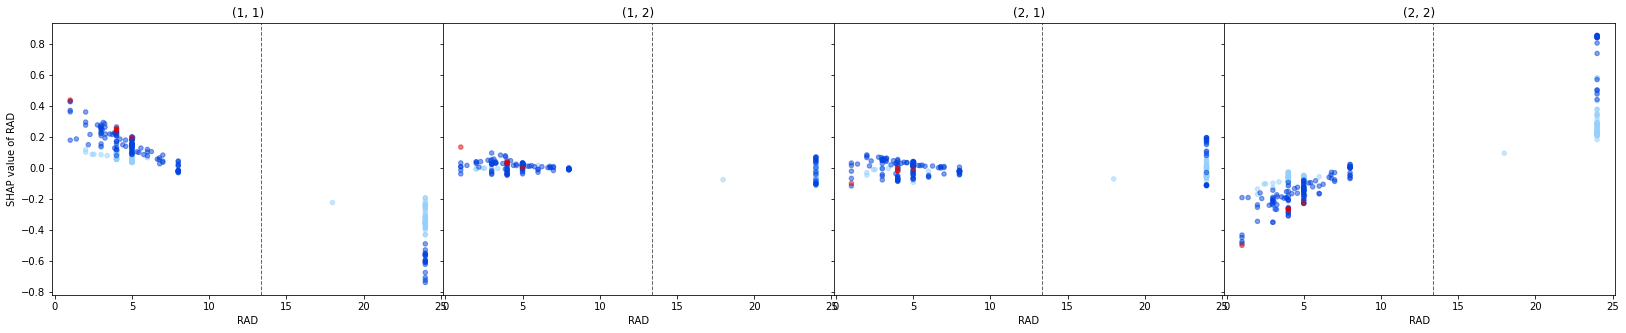

264.0 <= TAX <= 411.0
[]


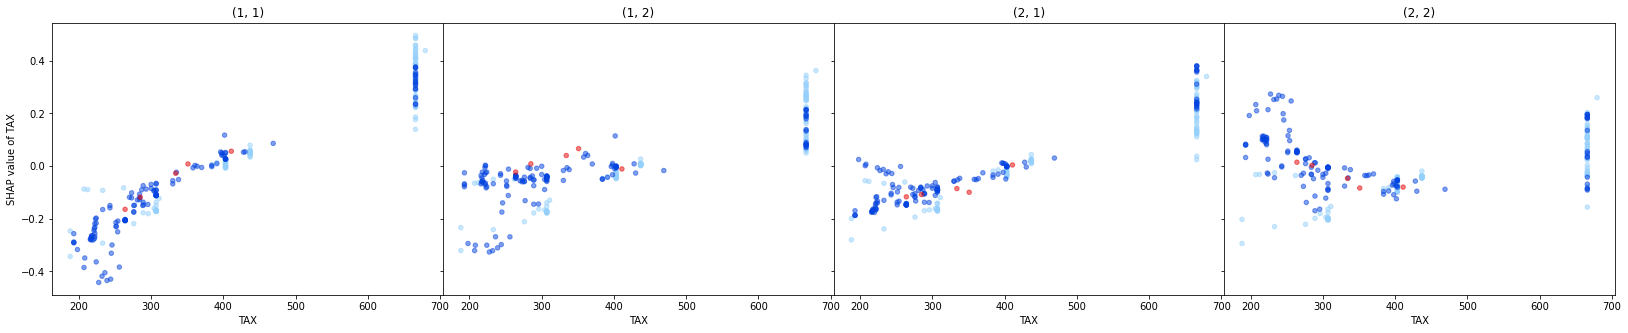

AGE <= 1.0
[Upper CF: AGE == 2.0 --> {'(2, 2)': 5}]


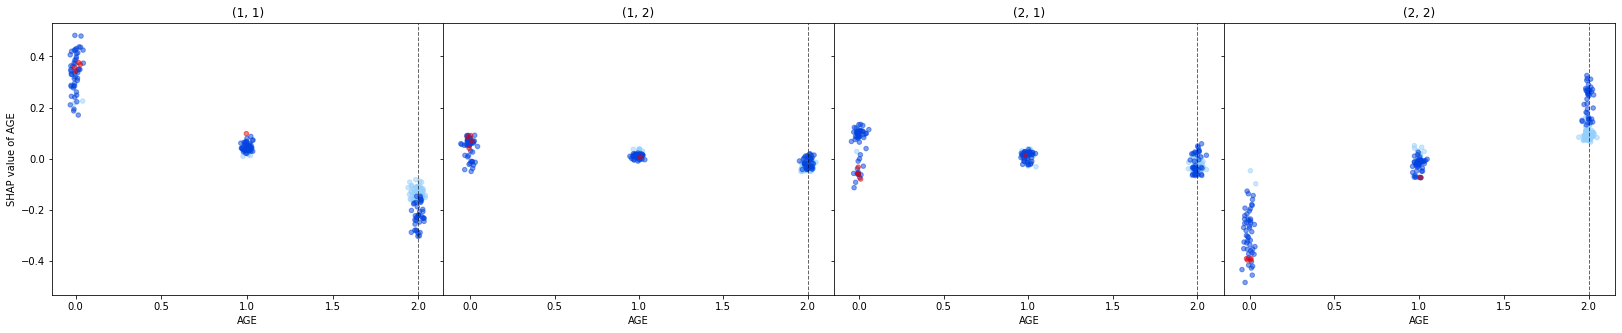

2.1153479553520422 <= DIS
[Lower CF: DIS == 1.94 --> {'(2, 2)': 5}]


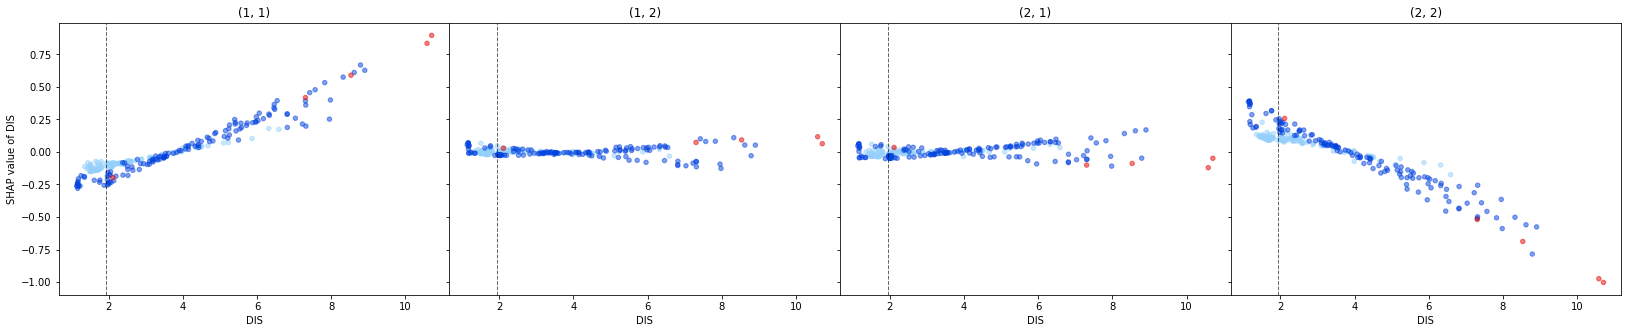

PTRATIO
[]


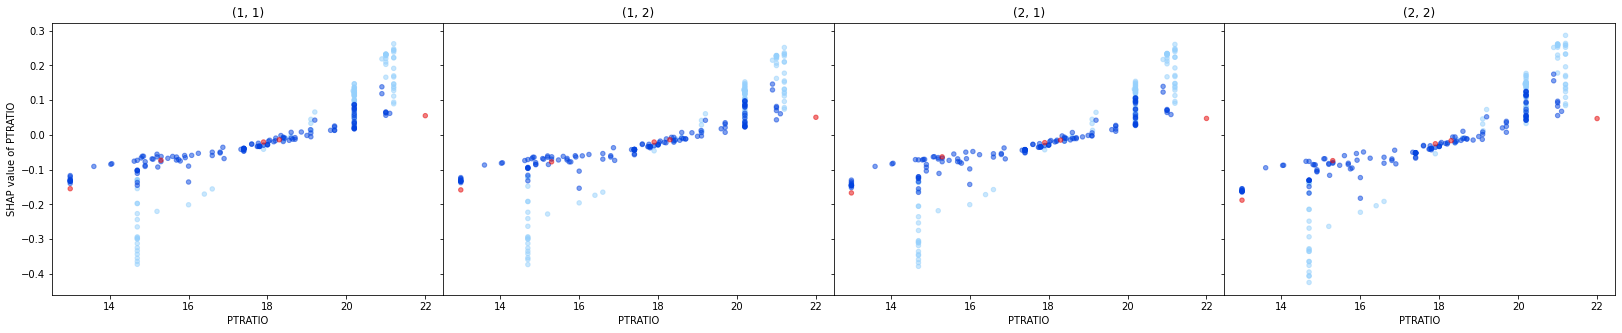

0.4 <= NOX <= 0.647
[]


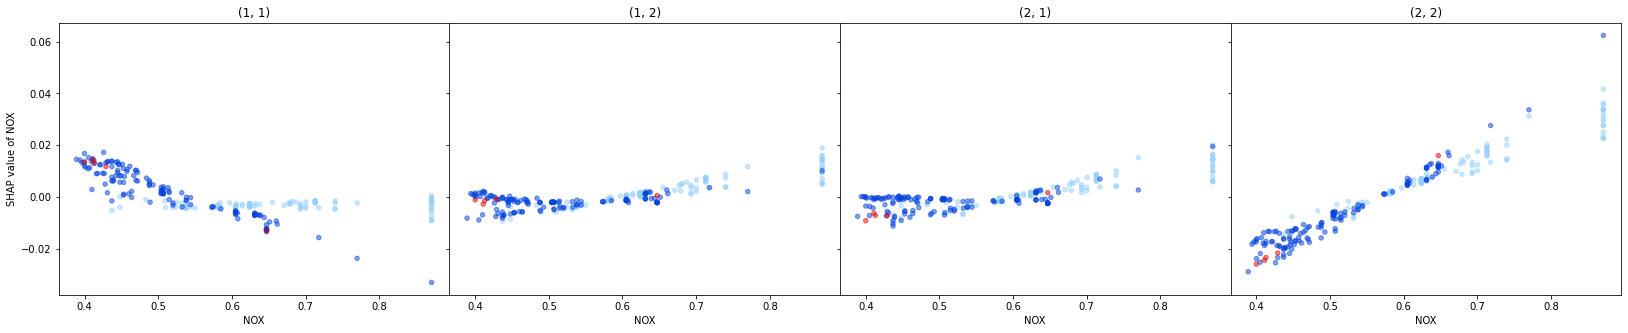

In [44]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)

### Node 1 (RLRRLR)

In [45]:
path = [node]
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLRRLRR,
 (1, 2)    3
 dtype: int64,
 1.2520571661171171)

In [46]:
node = node.parent
node, node.class_counts, node.distance

(RLRRLR,
 (1, 2)    3
 (1, 1)    1
 dtype: int64,
 1.7505269517991415)

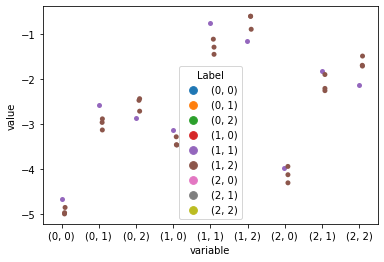

In [47]:
node.plot_outcomes()

The instance most similar is just across the boundary of ZN=20.

5.49 <= LSTAT <= 9.522242201272585
[Lower CF: LSTAT == 3.58 --> {'(2, 2)': 5},
 Upper CF: LSTAT == 11.59 --> {'(1, 1)': 5}]


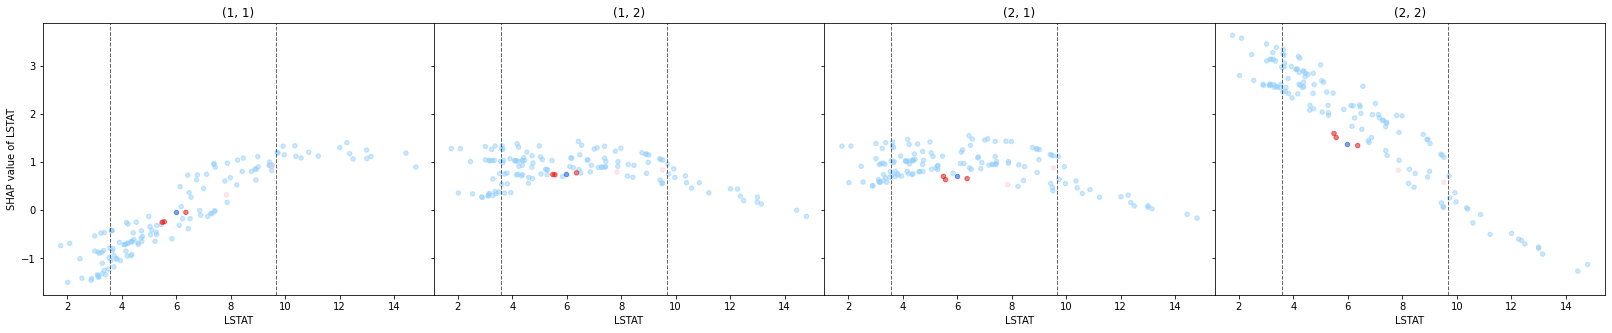

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 5}]


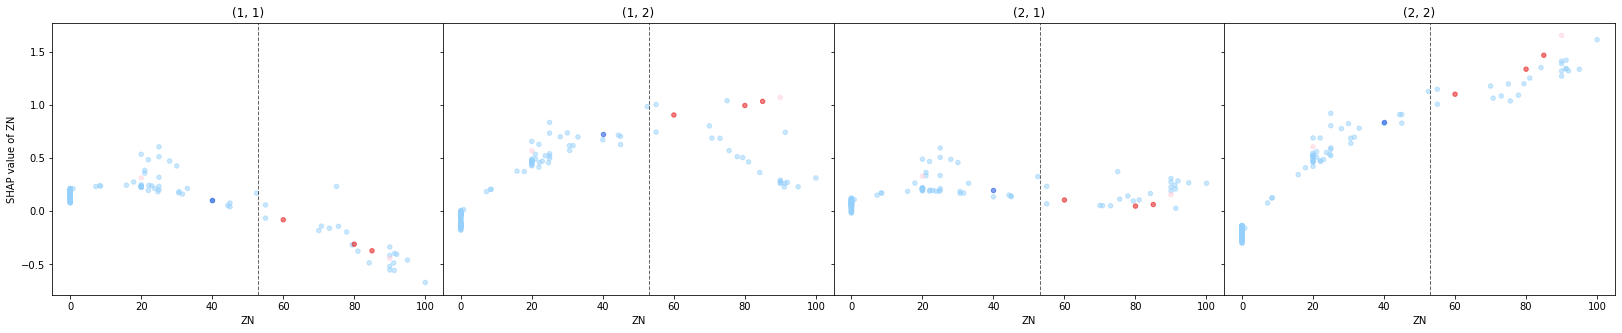

1.69 <= INDUS <= 4.15
[Upper CF: INDUS == 16.13 --> {'(1, 1)': 5}]


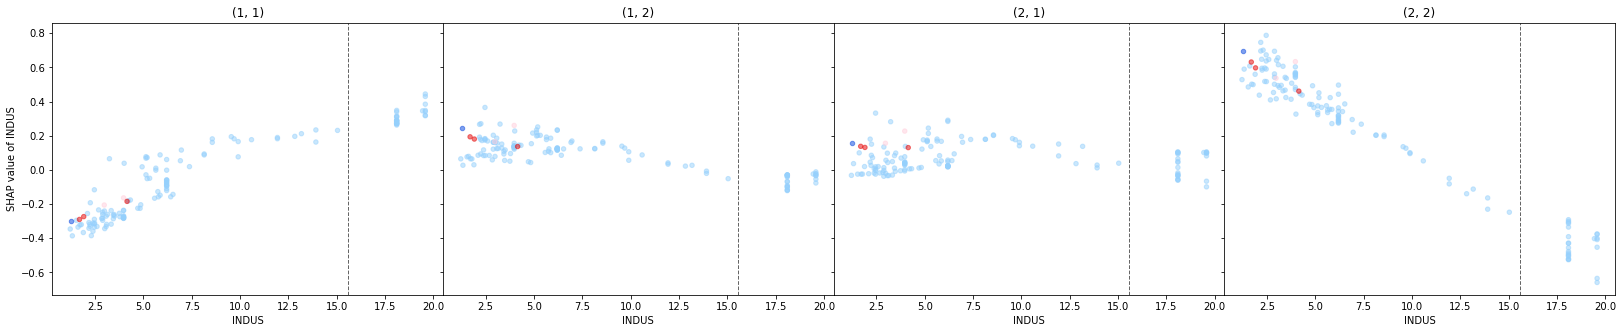

CRIM <= 0.539742303467232
[Upper CF: CRIM == 42.4 --> {'(2, 2)': 3, '(0, 0)': 1, '(1, 0)': 1}]


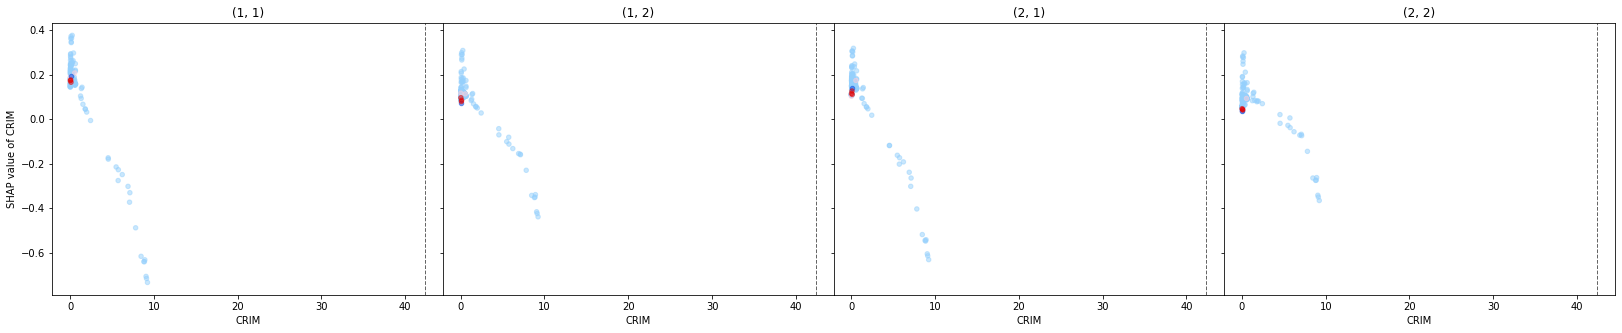

5.936 <= RM <= 7.225002872141104
[Upper CF: RM == 8.64 --> {'(2, 2)': 5}]


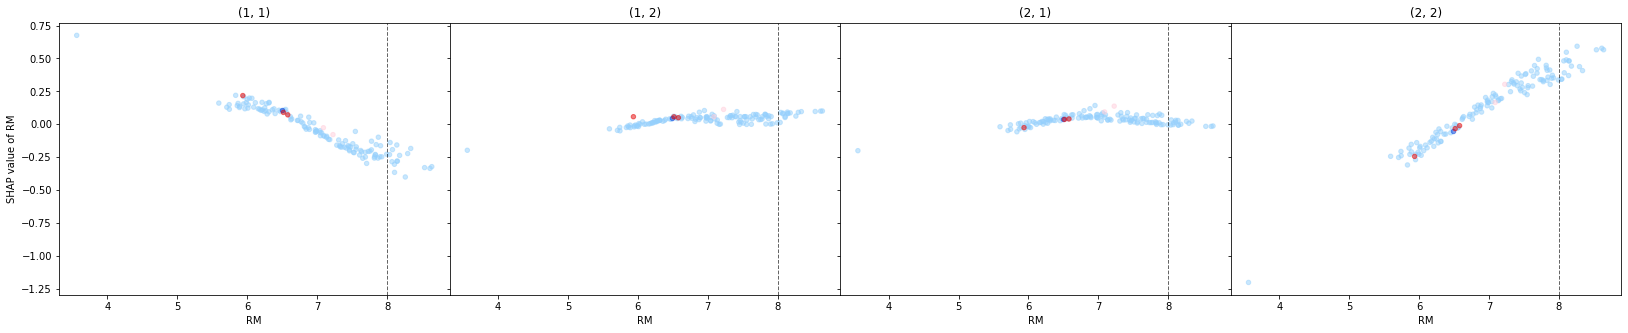

RAD <= 5.0
[Upper CF: RAD == 13.36 --> {'(2, 2)': 5}]


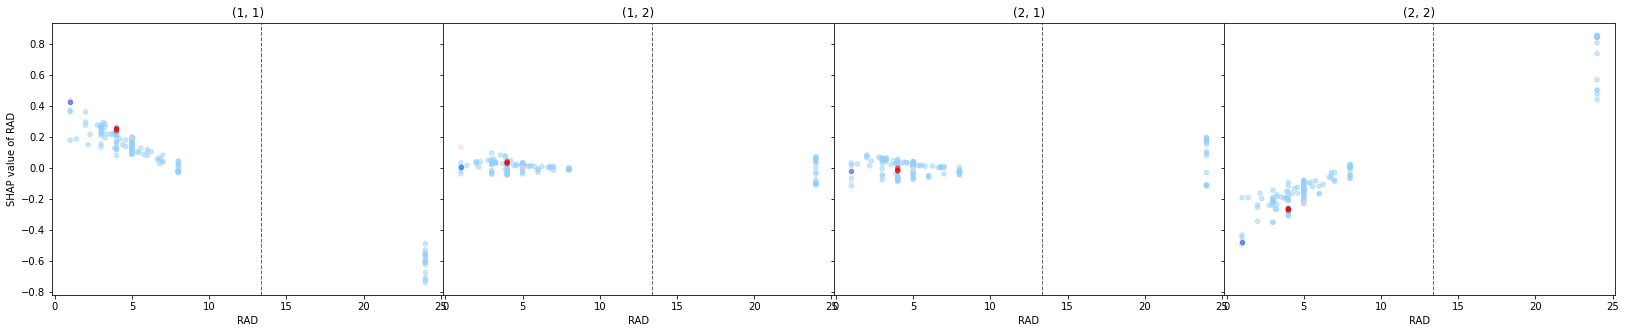

2.1153479553520422 <= DIS
[Lower CF: DIS == 1.94 --> {'(2, 2)': 5}]


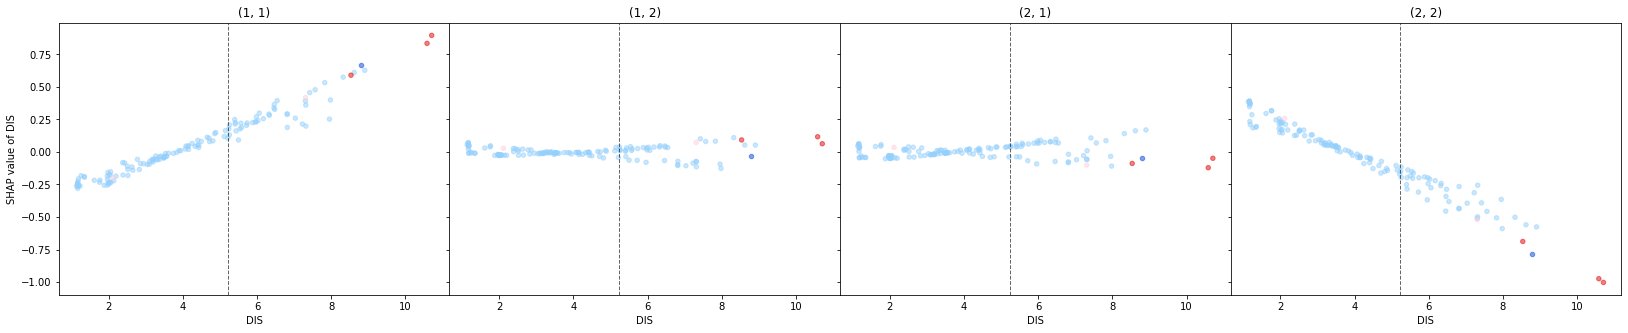

AGE <= 1.0
[Upper CF: AGE == 2.0 --> {'(2, 2)': 5}]


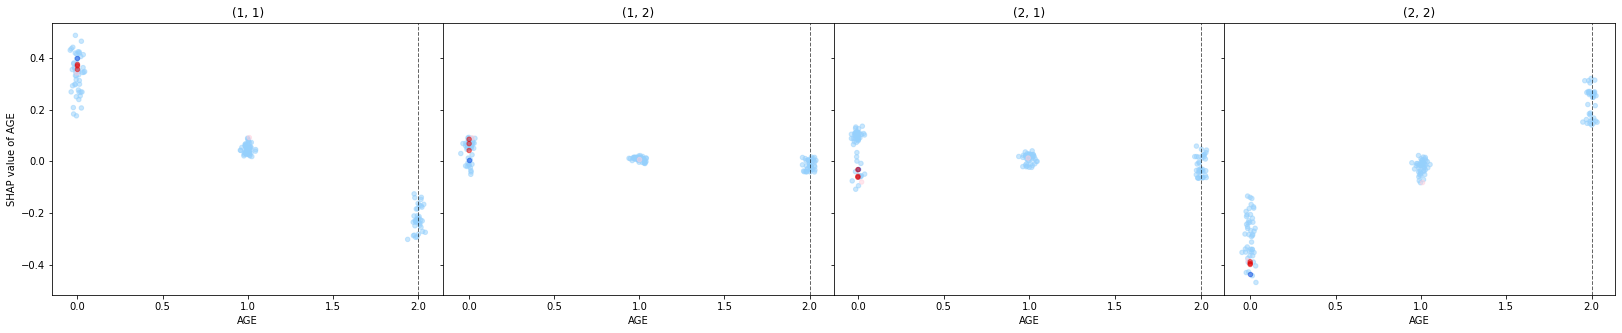

264.0 <= TAX <= 411.0
[]


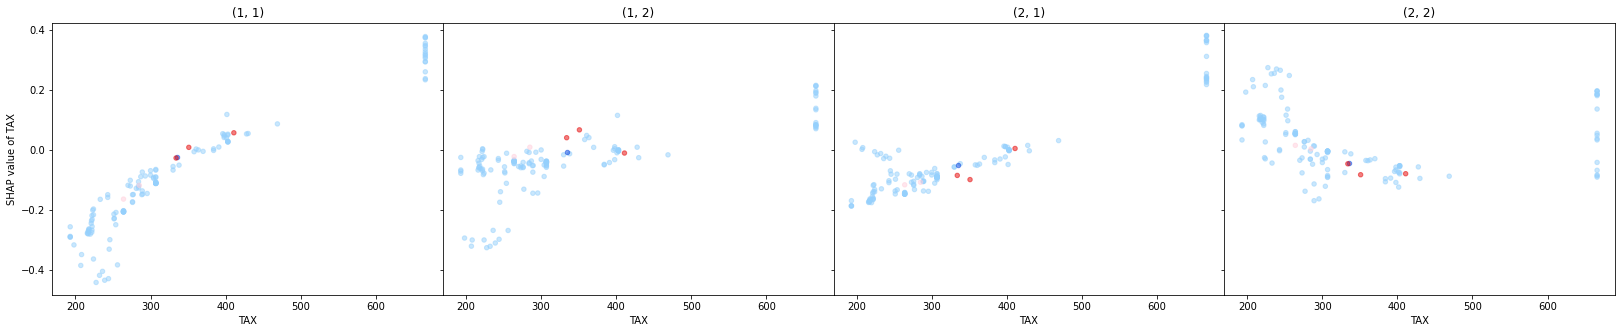

PTRATIO
[]


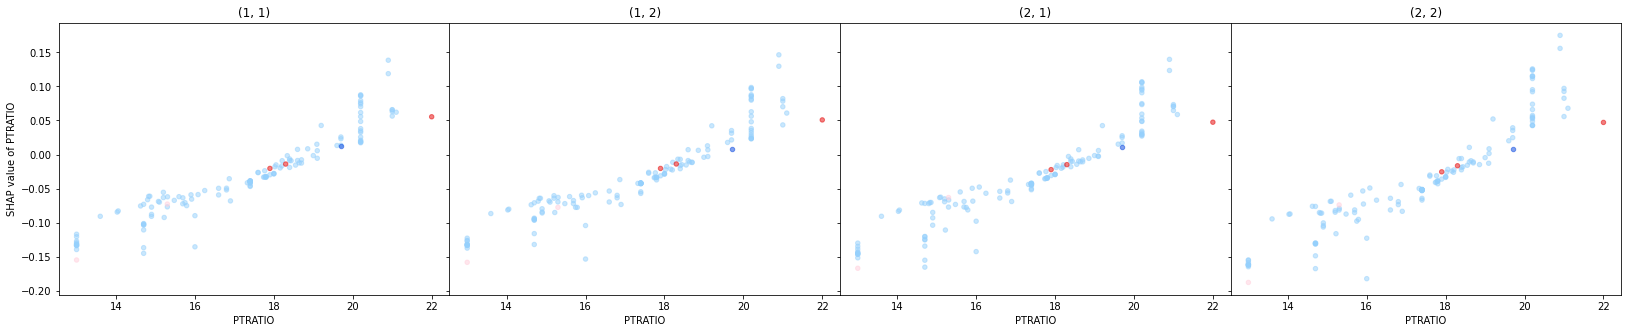

0.4 <= NOX <= 0.647
[]


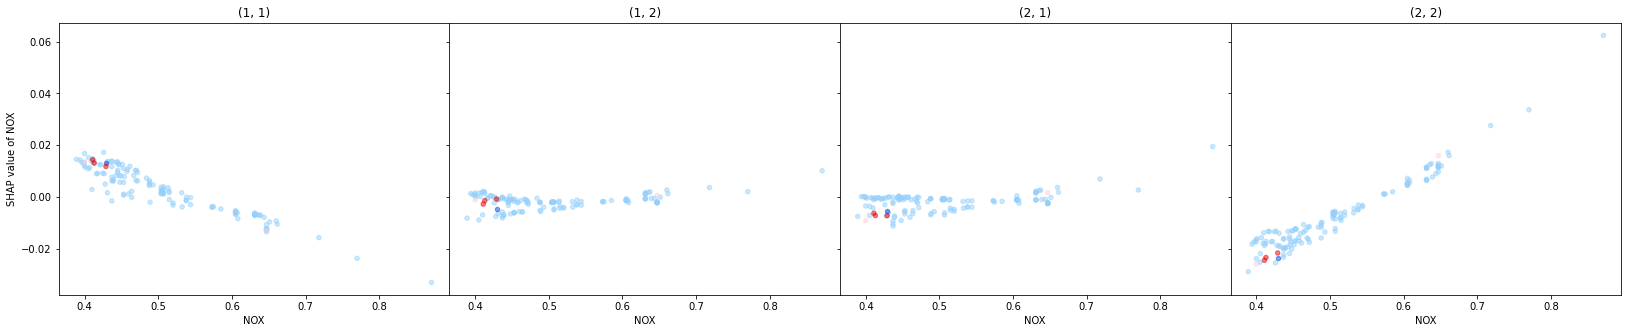

In [48]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True)

### Node 2 (RRRRR)

In [49]:
node = path[-1].right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRRRR,
 (1, 1)    5
 (1, 2)    2
 (2, 2)    1
 dtype: int64,
 7.198135143674191)

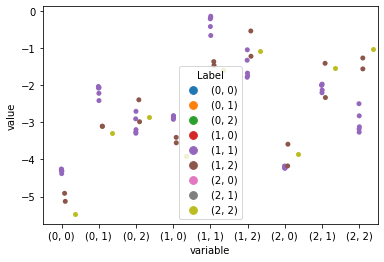

In [50]:
node.plot_outcomes()

5.49 <= LSTAT <= 9.522242201272585
[Lower CF: LSTAT == 3.58 --> {'(2, 2)': 5},
 Upper CF: LSTAT == 11.59 --> {'(1, 1)': 5}]


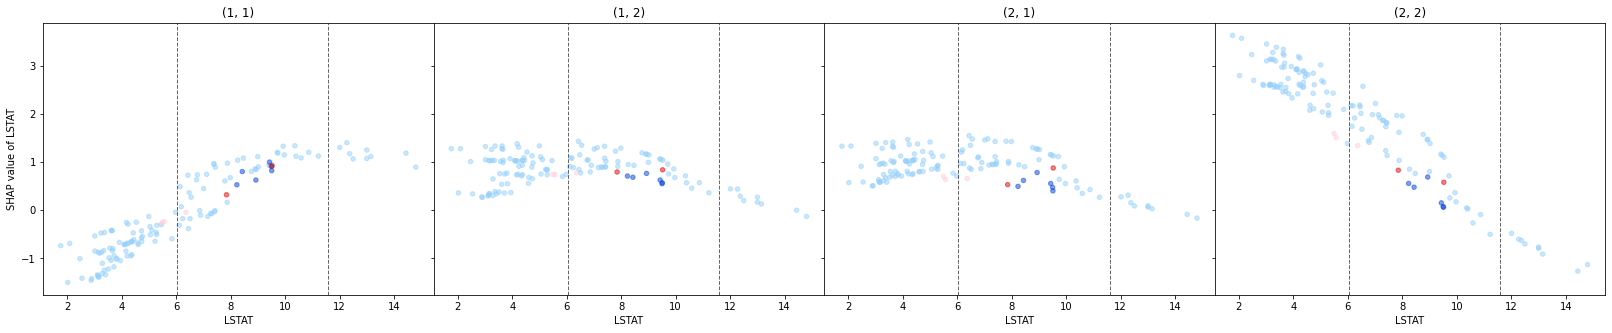

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 5}]


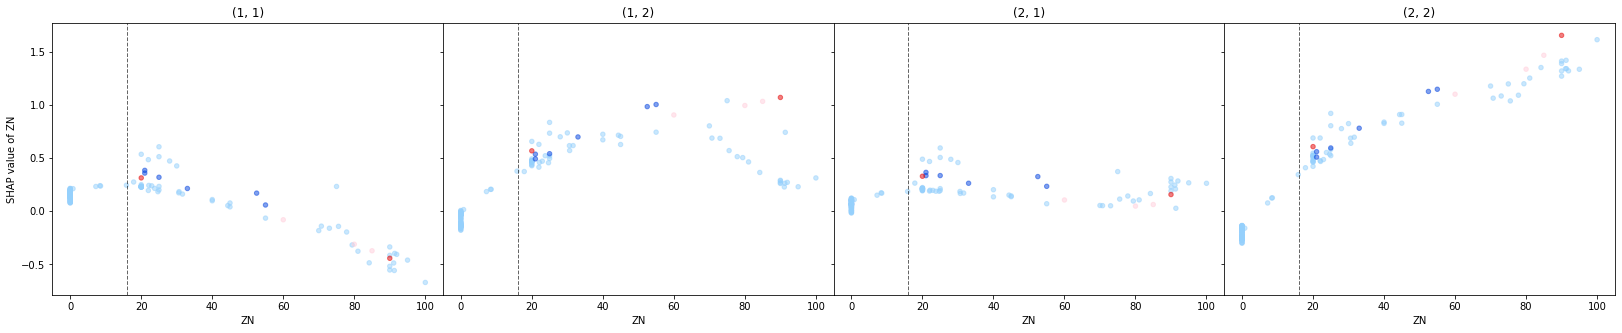

1.69 <= INDUS <= 4.15
[Upper CF: INDUS == 16.13 --> {'(1, 1)': 5}]


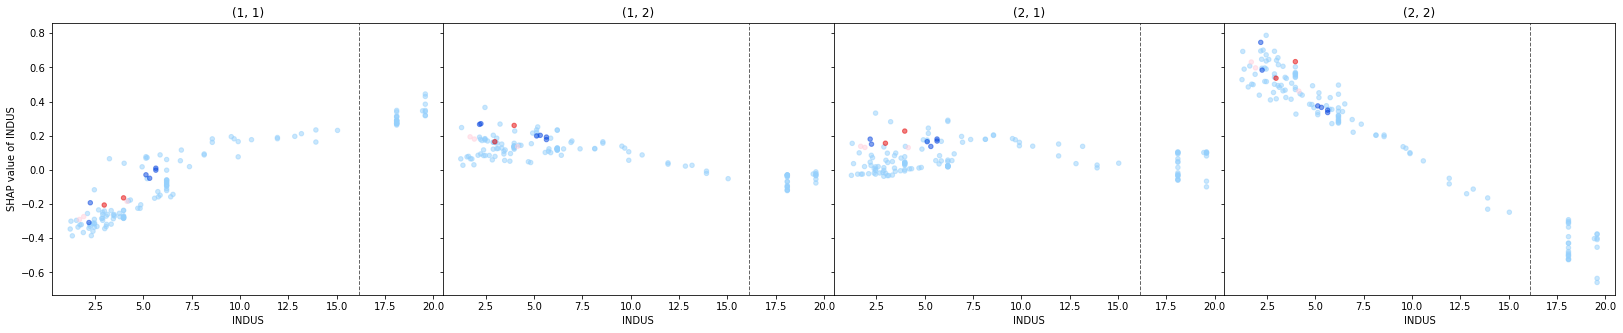

CRIM <= 0.539742303467232
[Upper CF: CRIM == 42.4 --> {'(2, 2)': 3, '(0, 0)': 1, '(1, 0)': 1}]


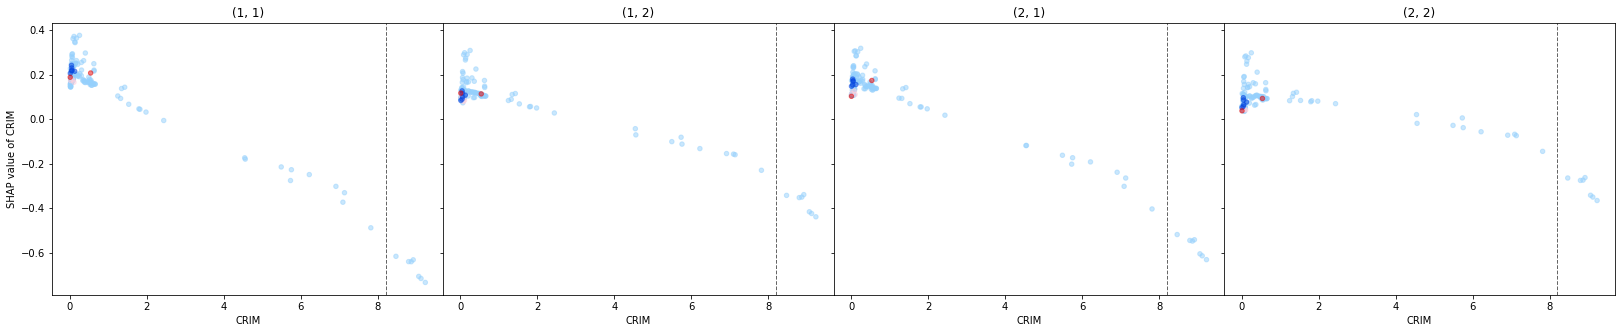

5.936 <= RM <= 7.225002872141104
[Upper CF: RM == 8.64 --> {'(2, 2)': 5}]


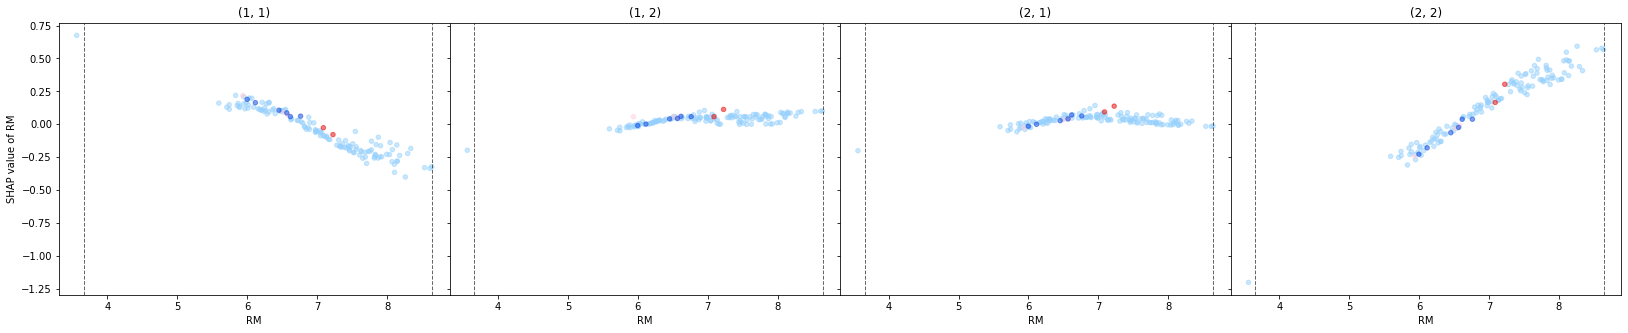

RAD <= 5.0
[Upper CF: RAD == 13.36 --> {'(2, 2)': 5}]


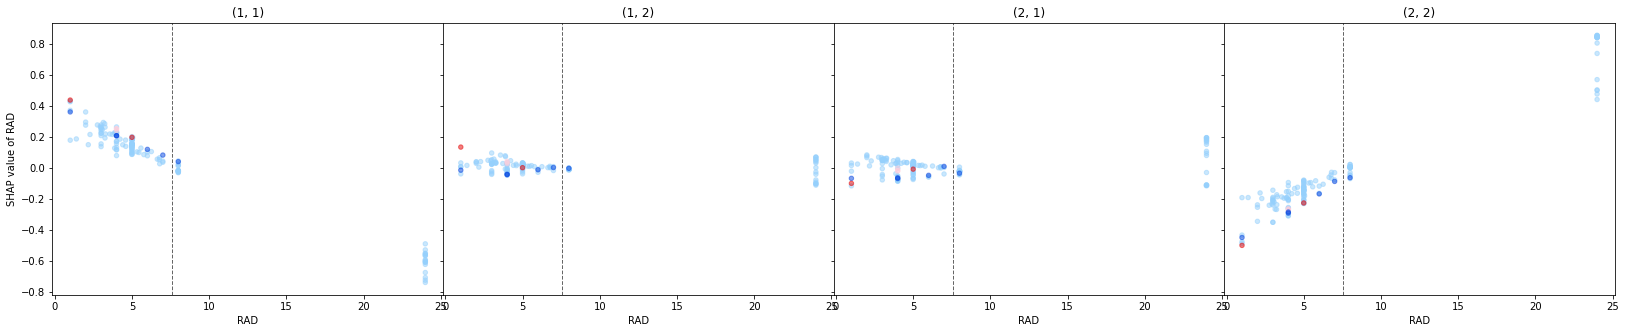

2.1153479553520422 <= DIS
[Lower CF: DIS == 1.94 --> {'(2, 2)': 5}]


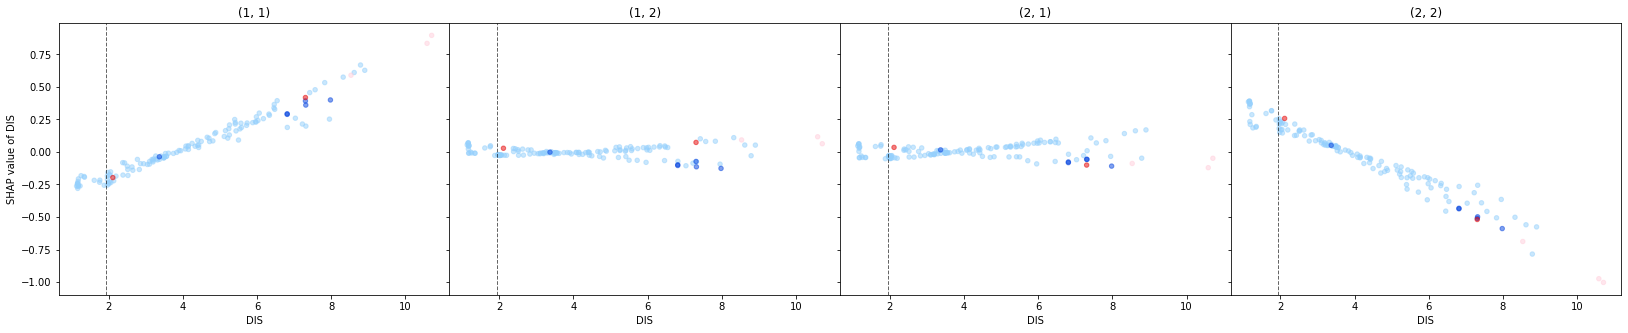

AGE <= 1.0
[Upper CF: AGE == 2.0 --> {'(2, 2)': 5}]


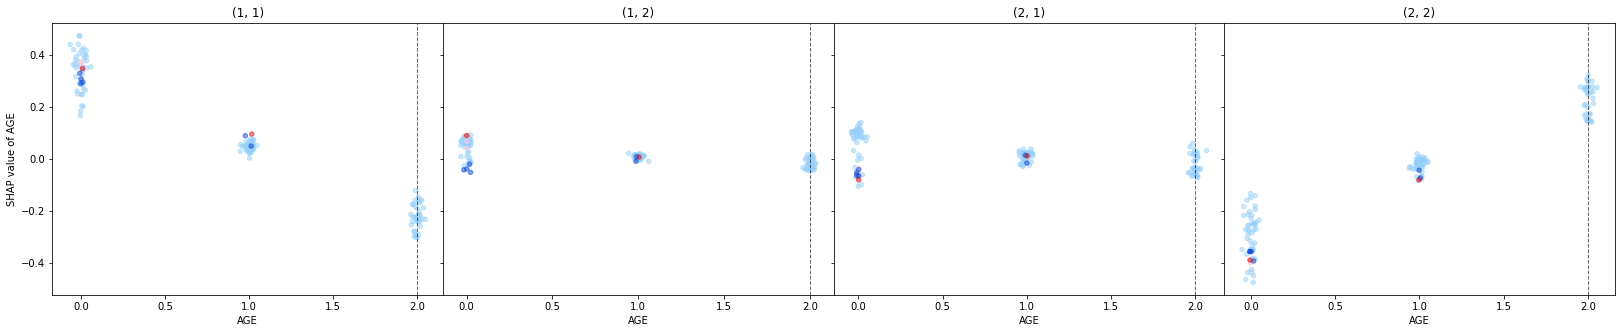

264.0 <= TAX <= 411.0
[]


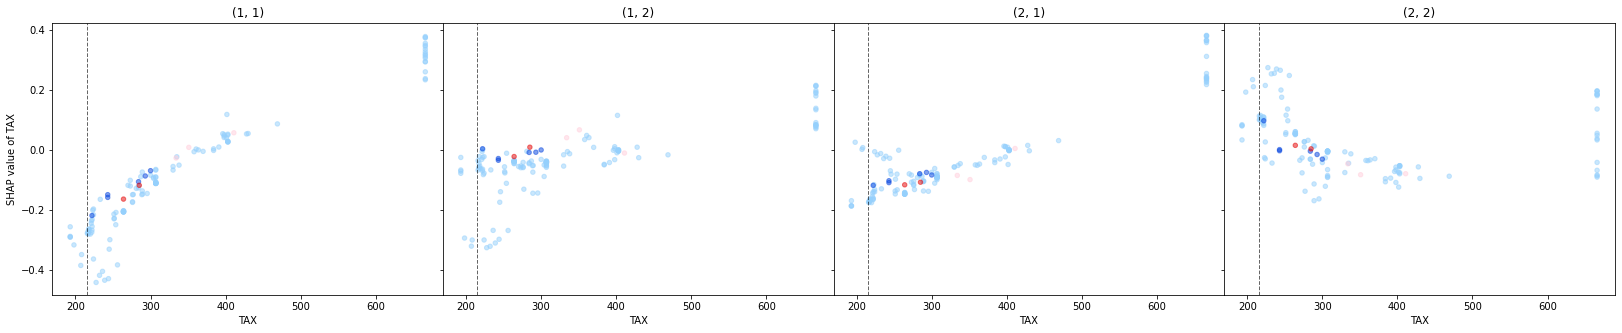

PTRATIO
[]


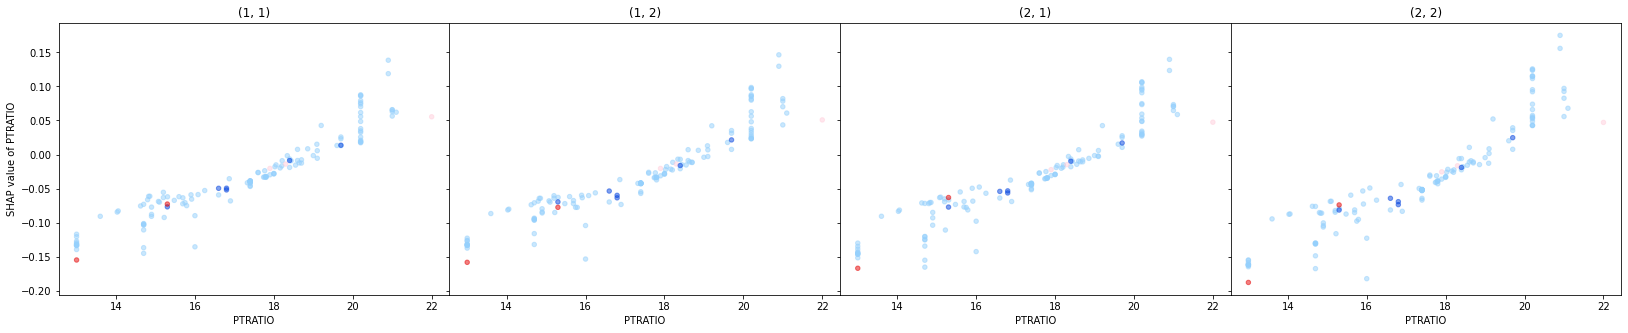

0.4 <= NOX <= 0.647
[]


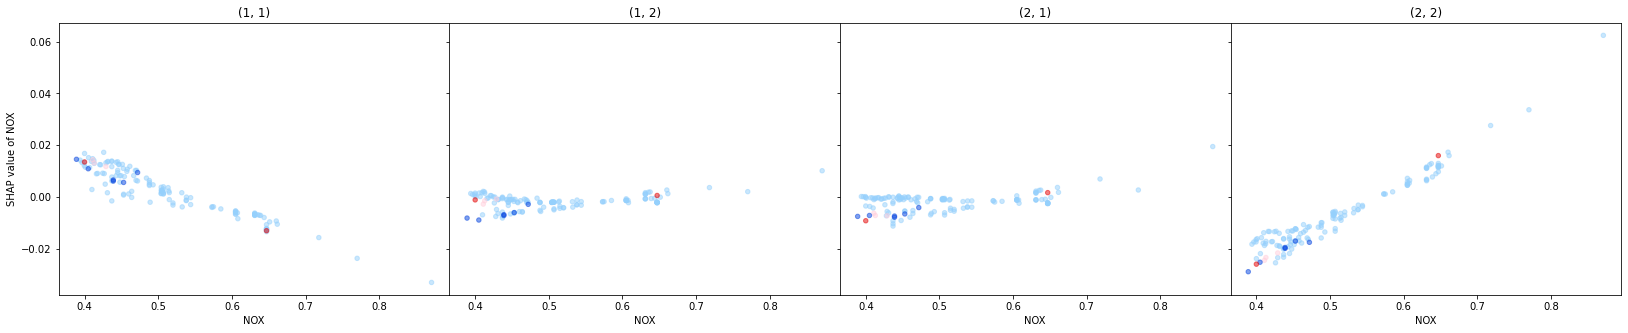

In [51]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True)

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 2}]


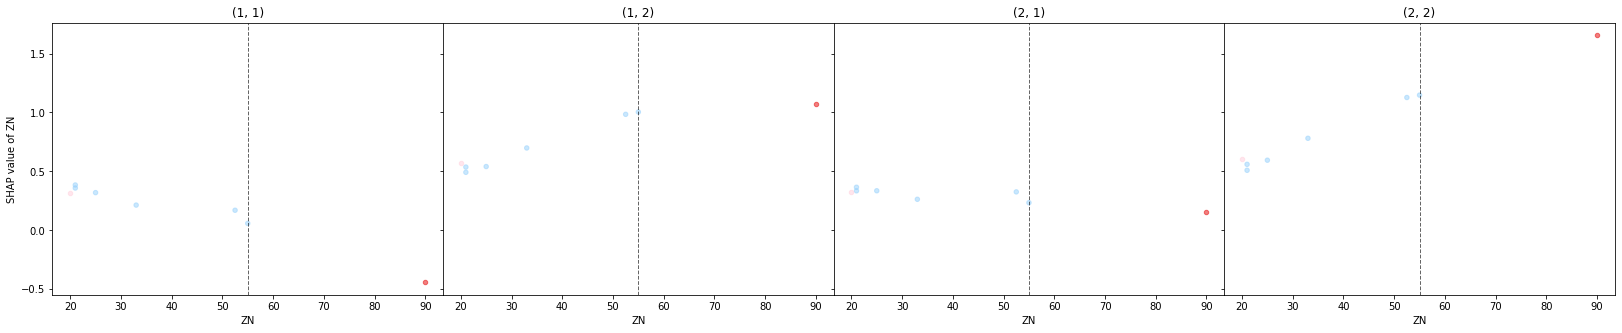

In [60]:
node.plot_feature_dependence('ZN', focus=node.get('L'), classes=classes, print_stats=True)

20.0 <= ZN <= 90.0
[Lower CF: ZN == 16.0 --> {'(1, 1)': 2}]


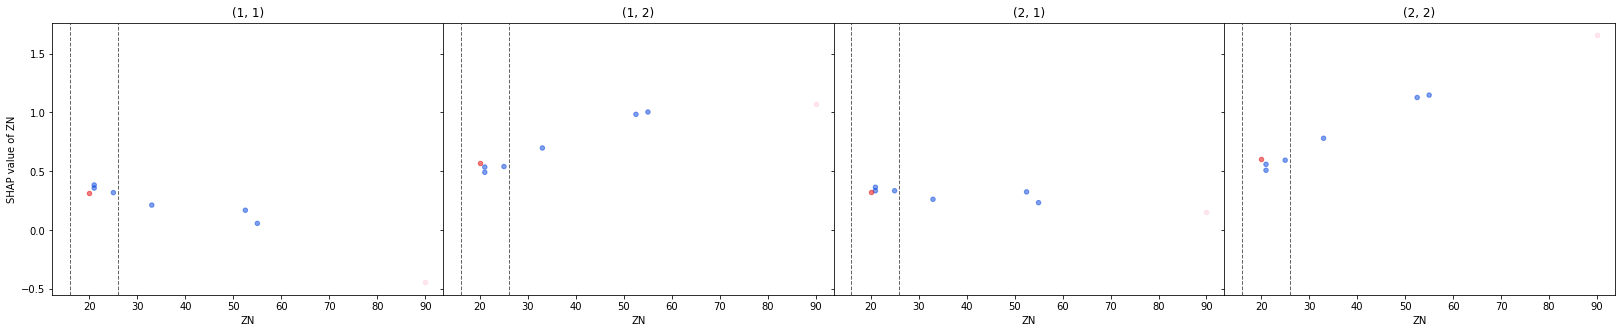

In [61]:
node.plot_feature_dependence('ZN', focus=node.get('R'), classes=classes, print_stats=True)

RAD <= 5.0
[Upper CF: RAD == 7.57 --> {'(2, 2)': 2}]


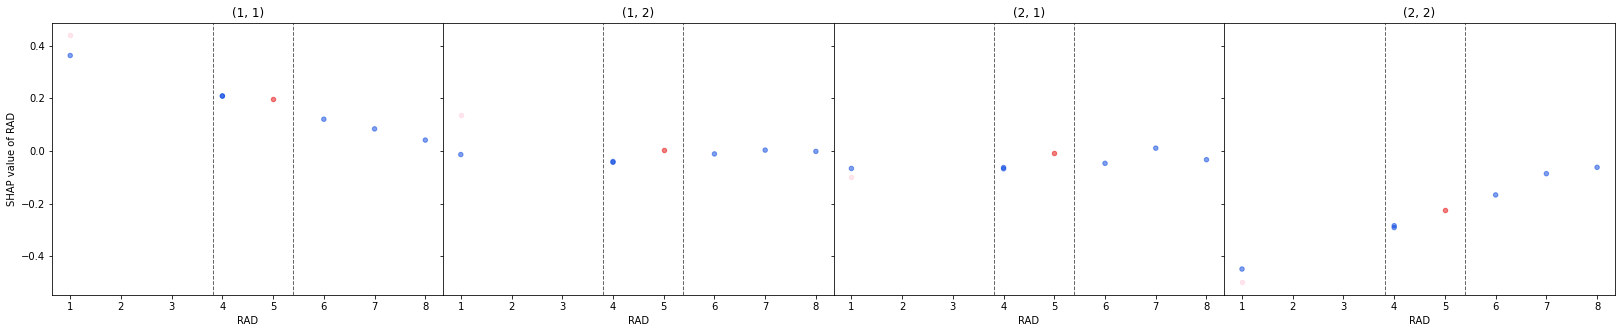

In [62]:
node.plot_feature_dependence('RAD', focus=node.get('R'), classes=classes, print_stats=True)

## $(2,1)$

In [63]:
node = load('(2, 1)')
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 149.33968539846273)

### Main Node (RRL)

In [64]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRL,
 (2, 2)    11
 (1, 1)    10
 (2, 1)     2
 dtype: int64,
 20.214452806269755)

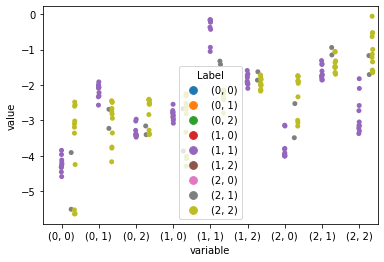

In [65]:
node.plot_outcomes()

6.48 <= LSTAT <= 7.12
[Lower CF: LSTAT == 6.05 --> {'(2, 2)': 2},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 2}]


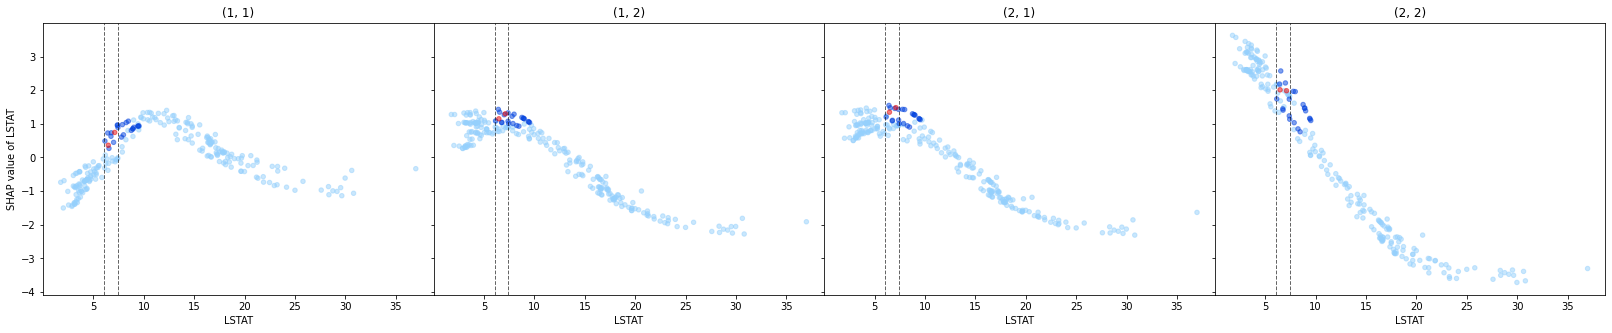

ZN == 0.0
[Upper CF: ZN == 19.0 --> {'(2, 2)': 2}]


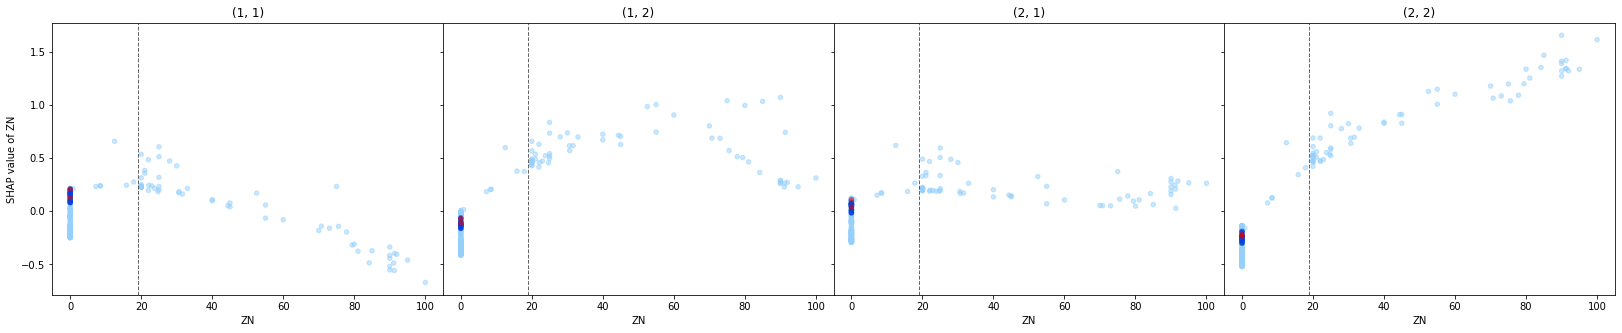

11.93 <= INDUS <= 18.1
[Lower CF: INDUS == 9.8 --> {'(2, 2)': 2},
 Upper CF: INDUS == 19.62 --> {'(1, 1)': 2}]


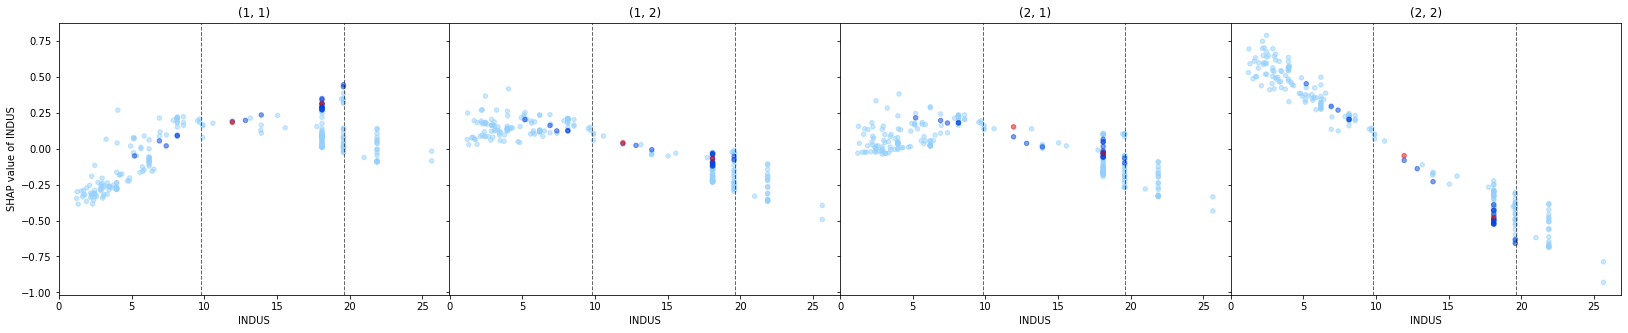

0.10959 <= CRIM <= 4.55587
[Upper CF: CRIM == 8.7 --> {'(2, 2)': 1, '(2, 0)': 1}]


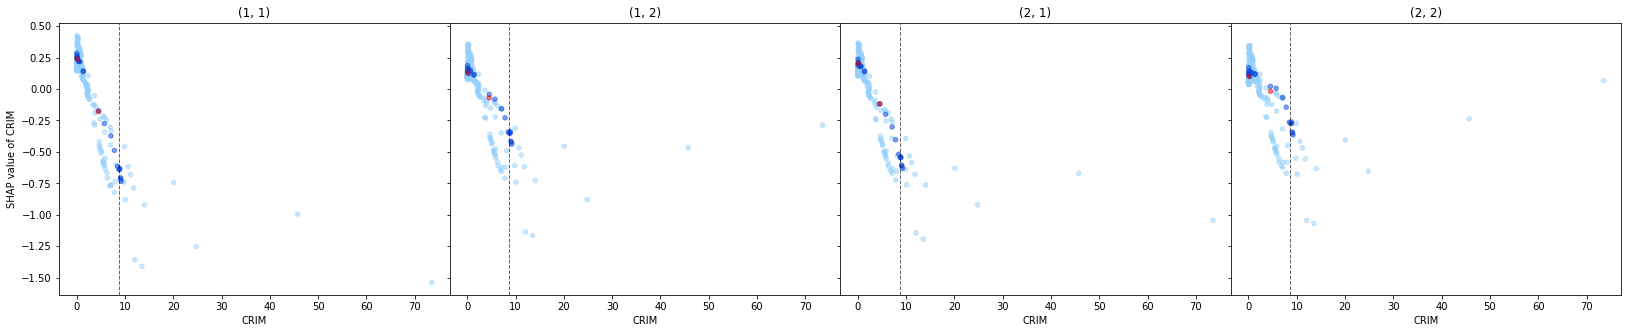

RM <= 6.794
[Upper CF: RM == 7.18 --> {'(2, 2)': 2}]


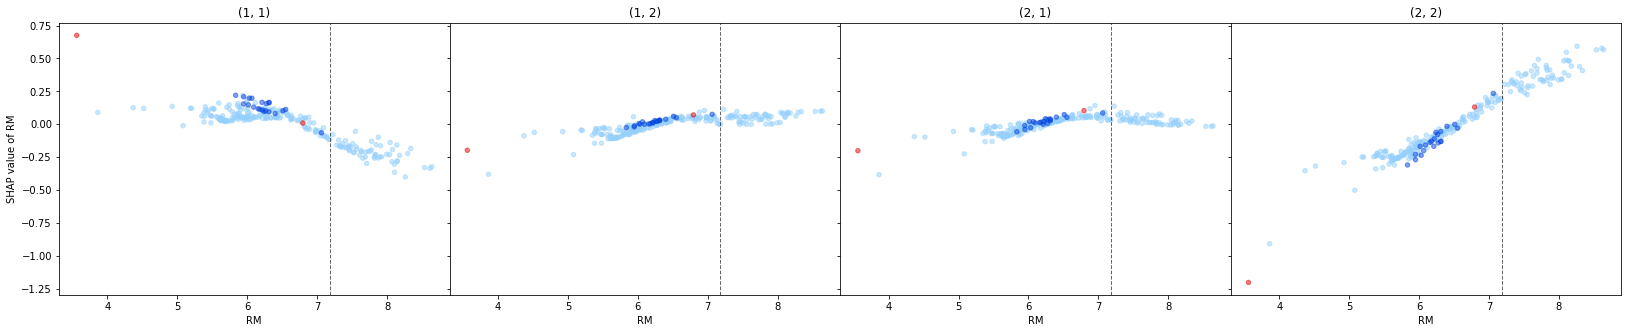

RAD
[]


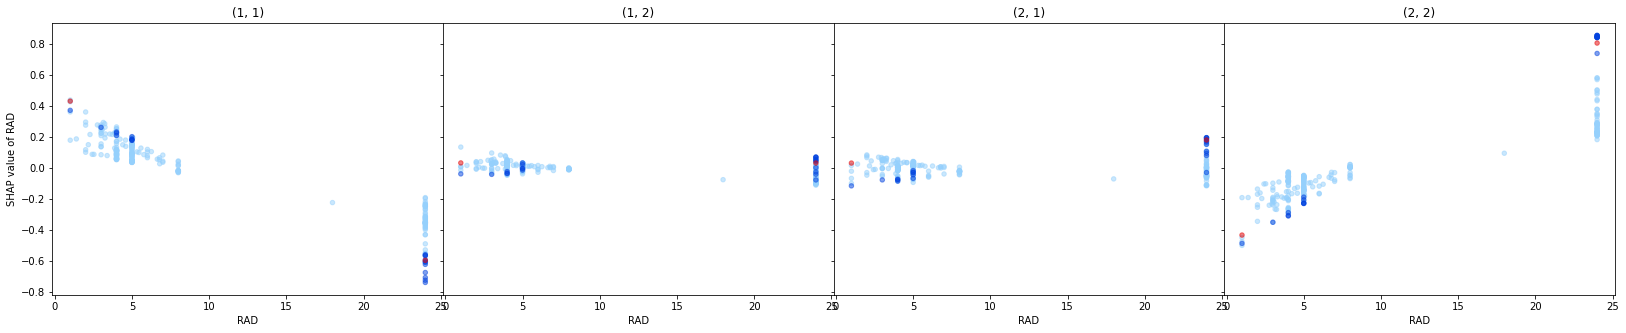

273.0 <= TAX <= 666.0
[]


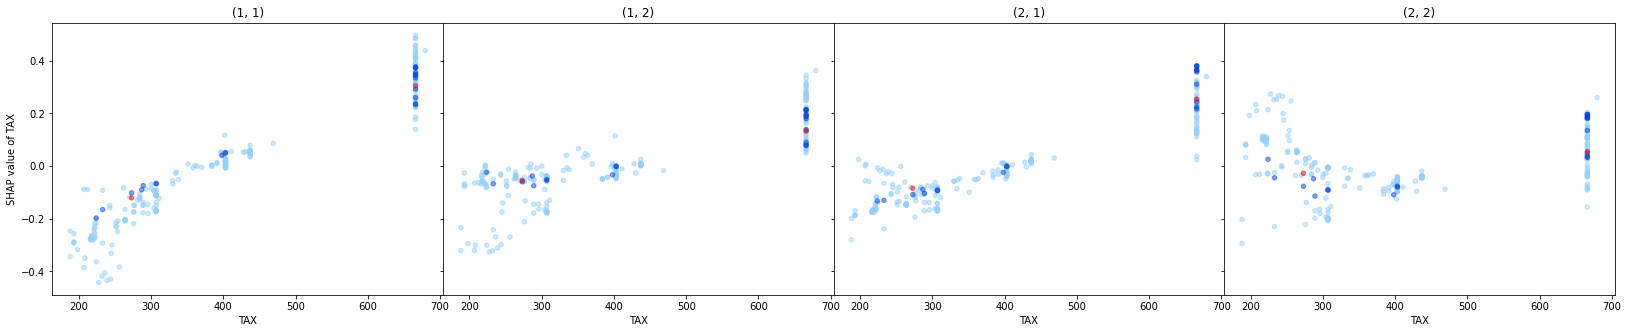

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 2}]


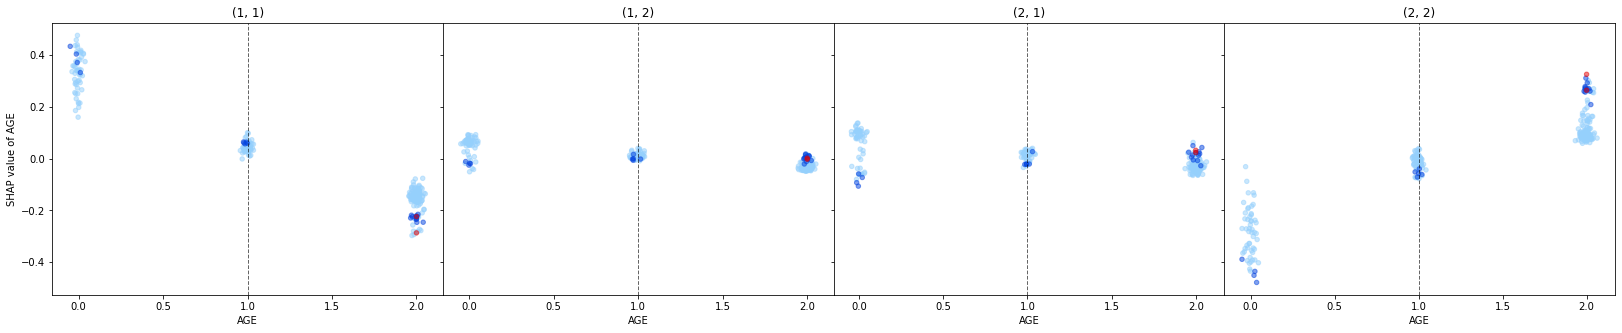

1.6132 <= DIS <= 2.3889
[Upper CF: DIS == 4.18 --> {'(1, 1)': 2}]


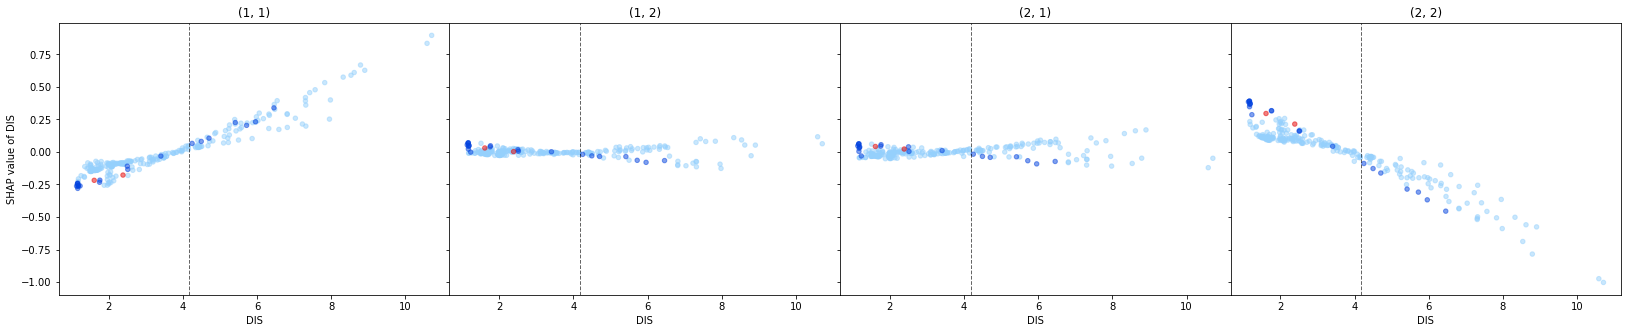

20.2 <= PTRATIO <= 21.0
[]


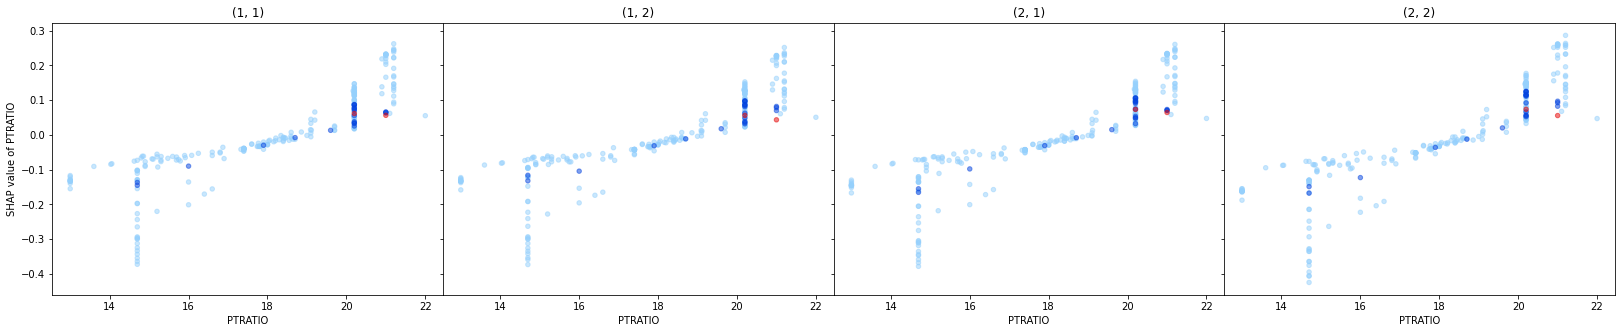

0.573 <= NOX <= 0.718
[]


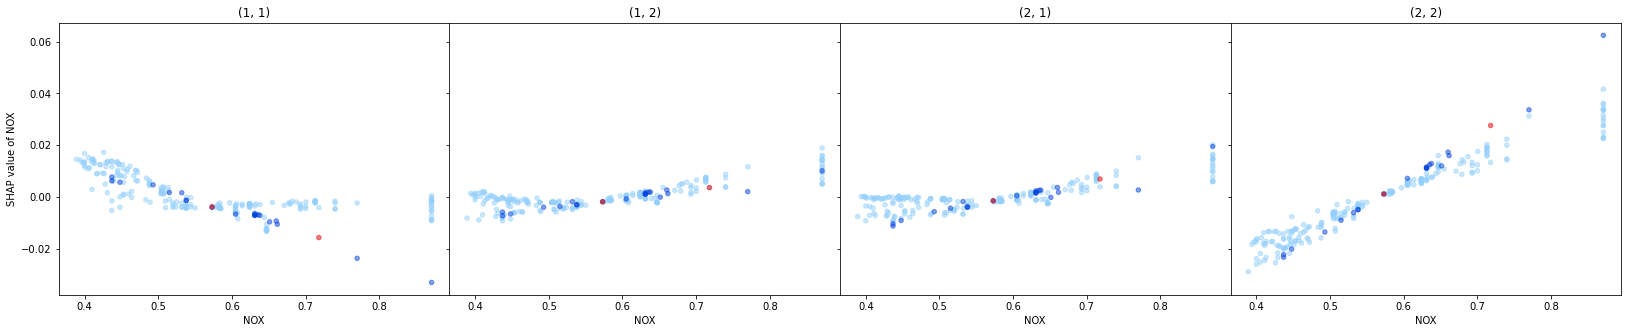

In [66]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)